# Repression Analysis

Examine repression of fibroblast genes in different clusters.

In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(Matrix)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)
library(matrixStats)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

## Load Data

In [2]:
rna = readRDS("../20220606_Multiome_RNA_Seurat/sessions/20220608_n7378/seurat.rds")

In [29]:
# Metadata file for scATAC + Multiome ATAC
atac_metaData = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.w.transfer.cluster.tsv", header = T, stringsAsFactor=F)
# atac_metaData = read.table("../20220609_Multiome_SnapATAC/metadata.no.harmony.tsv", header = T, stringsAsFactor=F)
rownames(atac_metaData) = paste(atac_metaData$sample, atac_metaData$barcode, sep='_')
atac_metaData$cells = rownames(atac_metaData)
dim(atac_metaData)
head(atac_metaData, 5)

[1] 13525    12

barcode                  TN    UM    PP    UQ   
D1M_AAAAAAAAAAACATGCTATTAGCC AAAAAAAAAAACATGCTATTAGCC  6736  6736  6736  6729
D1M_AAAAAAAAAAACATGCTCACCCTC AAAAAAAAAAACATGCTCACCCTC 28369 28369 28369 28339
D1M_AAAAAAAAAAACATGCTTGAGAAC AAAAAAAAAAACATGCTTGAGAAC 28635 28635 28635 28609
D1M_AAAAAAAAAAACCATGAACCTTGT AAAAAAAAAAACCATGAACCTTGT 33869 33869 33869 33838
D1M_AAAAAAAAAAACCATGAGCTTAAA AAAAAAAAAAACCATGAGCTTAAA 18885 18885 18885 18867
                             CM   cluster umap1      umap2     sample
D1M_AAAAAAAAAAACATGCTATTAGCC  373 3       -0.4031222 -3.454888 D1M   
D1M_AAAAAAAAAAACATGCTCACCCTC 2447 5        2.6643078 -3.955240 D1M   
D1M_AAAAAAAAAAACATGCTTGAGAAC 2201 1       -0.2071755  2.688192 D1M   
D1M_AAAAAAAAAAACCATGAACCTTGT 3018 5        3.1269215 -4.609105 D1M   
D1M_AAAAAAAAAAACCATGAGCTTAAA 1514 1       -0.1988264  1.998739 D1M   
                             cells                        transfered_cluster
D1M_AAAAAAAAAAACATGCTATTAGCC D1M_AAAAAAAAAAACATGCTATTAGCC  3                
D1M_AAAAAAAAAAACATGCTCACCCTC D1M_AAAAAAAAAAACATGCTCACCCTC  3                
D1M_AAAAAAAAAAACATGCTTGAGAAC D1M_AAAAAAAAAAACATGCTTGAGAAC 15                
D1M_AAAAAAAAAAACCATGAACCTTGT D1M_AAAAAAAAAAACCATGAACCTTGT  3                
D1M_AAAAAAAAAAACCATGAGCTTAAA D1M_AAAAAAAAAAACCATGAGCTTAAA 15

In [31]:
atac_metaData_multiome_filt = atac_metaData[atac_metaData$sample!="D2", ]
dim(atac_metaData_multiome_filt)

[1] 7378   12

In [5]:
atac_to_rna_bc_map = read.table("/srv/scratch/surag/scMultiome-reprog/ATAC.RNA.bc.map.tsv", sep='\t', 
                                header=F, stringsAsFactors=F)
colnames(atac_to_rna_bc_map) = c("ATAC", "RNA")
rownames(atac_to_rna_bc_map) = paste("AAAAAAAA", atac_to_rna_bc_map$ATAC, sep='')
head(atac_to_rna_bc_map)

ATAC             RNA             
AAAAAAAAGTAACACACCCGCTGT GTAACACACCCGCTGT AAACAGCCAAACAACA
AAAAAAAAAAGAACAACCCGCTGT AAGAACAACCCGCTGT AAACAGCCAAACATAG
AAAAAAAAGCCTGTTACCCGCTGT GCCTGTTACCCGCTGT AAACAGCCAAACCCTA
AAAAAAAATTCGCGCACCCGCTGT TTCGCGCACCCGCTGT AAACAGCCAAACCTAT
AAAAAAAAATGGAGGACCCGCTGT ATGGAGGACCCGCTGT AAACAGCCAAACCTTG
AAAAAAAAAACCATGACCCGCTGT AACCATGACCCGCTGT AAACAGCCAAACGCGA

In [6]:
all(atac_metaData_multiome_filt$barcode %in% rownames(atac_to_rna_bc_map))

[1] TRUE

In [7]:
head(atac_metaData_multiome_filt)

barcode                  TN    UM    PP    UQ   
D1M_AAAAAAAAAAACATGCTATTAGCC AAAAAAAAAAACATGCTATTAGCC  6736  6736  6736  6729
D1M_AAAAAAAAAAACATGCTCACCCTC AAAAAAAAAAACATGCTCACCCTC 28369 28369 28369 28339
D1M_AAAAAAAAAAACATGCTTGAGAAC AAAAAAAAAAACATGCTTGAGAAC 28635 28635 28635 28609
D1M_AAAAAAAAAAACCATGAACCTTGT AAAAAAAAAAACCATGAACCTTGT 33869 33869 33869 33838
D1M_AAAAAAAAAAACCATGAGCTTAAA AAAAAAAAAAACCATGAGCTTAAA 18885 18885 18885 18867
D1M_AAAAAAAAAAACCATGATATAGGC AAAAAAAAAAACCATGATATAGGC 12385 12385 12385 12370
                             CM   cluster umap1      umap2     sample
D1M_AAAAAAAAAAACATGCTATTAGCC  373 3       -0.4031222 -3.454888 D1M   
D1M_AAAAAAAAAAACATGCTCACCCTC 2447 5        2.6643078 -3.955240 D1M   
D1M_AAAAAAAAAAACATGCTTGAGAAC 2201 1       -0.2071755  2.688192 D1M   
D1M_AAAAAAAAAAACCATGAACCTTGT 3018 5        3.1269215 -4.609105 D1M   
D1M_AAAAAAAAAAACCATGAGCTTAAA 1514 1       -0.1988264  1.998739 D1M   
D1M_AAAAAAAAAAACCATGATATAGGC 1282 5        1.7942727 -3.712197 D1M   
                             cells                       
D1M_AAAAAAAAAAACATGCTATTAGCC D1M_AAAAAAAAAAACATGCTATTAGCC
D1M_AAAAAAAAAAACATGCTCACCCTC D1M_AAAAAAAAAAACATGCTCACCCTC
D1M_AAAAAAAAAAACATGCTTGAGAAC D1M_AAAAAAAAAAACATGCTTGAGAAC
D1M_AAAAAAAAAAACCATGAACCTTGT D1M_AAAAAAAAAAACCATGAACCTTGT
D1M_AAAAAAAAAAACCATGAGCTTAAA D1M_AAAAAAAAAAACCATGAGCTTAAA
D1M_AAAAAAAAAAACCATGATATAGGC D1M_AAAAAAAAAAACCATGATATAGGC

In [8]:
rna_bc_order = paste(atac_to_rna_bc_map[atac_metaData_multiome_filt$barcode, "RNA"], ifelse(atac_metaData_multiome_filt$sample=="D1M", 1, 2), sep='-')
head(rna_bc_order)

[1] "CAAACCGTCCAATAGC-1" "TACTTCGTCCAATAGC-1" "TTTGTGTTCCAATAGC-1"
[4] "CTCTCACAGATAAAGC-1" "GGCCTTAAGATAAAGC-1" "CCAAGTTAGATAAAGC-1"

In [9]:
all(rna_bc_order %in% colnames(rna))

[1] TRUE

In [662]:
# fibr_genes = as.character(unlist(read.table("../20200828_RNA_Seurat/lists/fibroblast.genes.txt")$V1))
# fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
# length(fibr_genes)

In [1029]:
fibr_genes = as.character(unlist(read.table("./fibr_ipsc_diff.txt")$V1))
length(fibr_genes)
fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
length(fibr_genes)

[1] 1113

[1] 1113

In [663]:
fibr_genes = c(as.character(unlist(read.table("../20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx1.txt")$V1)),
               as.character(unlist(read.table("../20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx2.txt")$V1)))
length(fibr_genes)
fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
length(fibr_genes)

[1] 646

[1] 644

In [144]:
et_genes = as.character(unlist(read.table("../20200828_RNA_Seurat/gene_sets/20211004_znorm_n15/idx10.txt")$V1))
length(et_genes)
et_genes = et_genes[et_genes %in% rownames(rna)]
length(et_genes)

[1] 370

[1] 358

In [12]:
# Metadata file for scATAC
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
scatac_only_metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(scatac_only_metaData) = paste(scatac_only_metaData$sample, scatac_only_metaData$barcode, sep='_')
scatac_only_metaData$cells = rownames(scatac_only_metaData)
scatac_only_metaData = scatac_only_metaData[scatac_only_metaData$sample=="D2", ]
rownames(scatac_only_metaData) = scatac_only_metaData$barcode
dim(scatac_only_metaData)
head(scatac_only_metaData, 5)

[1] 6559    6

barcode          sample umap1     umap2      cluster
AAACAACGAGAAGTTA AAACAACGAGAAGTTA D2     -2.582804  1.0539784 10     
AAACAACGAGACTGTT AAACAACGAGACTGTT D2     -3.609249  0.2938383 15     
AAACCCTGAGTACGTT AAACCCTGAGTACGTT D2     -3.560982 -6.2913636 13     
AAACCGTACCACCTAA AAACCGTACCACCTAA D2     -2.479006 -3.8390841  3     
AAACCGTACGCCCTAG AAACCGTACGCCCTAG D2     -3.901256  0.8696430 15     
                 cells              
AAACAACGAGAAGTTA D2_AAACAACGAGAAGTTA
AAACAACGAGACTGTT D2_AAACAACGAGACTGTT
AAACCCTGAGTACGTT D2_AAACCCTGAGTACGTT
AAACCGTACCACCTAA D2_AAACCGTACCACCTAA
AAACCGTACGCCCTAG D2_AAACCGTACGCCCTAG

In [13]:
# fibr_genes

In [14]:
atac_bmat = readMM("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/5kb.sparse.mm")

In [15]:
atac_pmat = readMM("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/pmat.sparse.mm")

In [16]:
atac_bins = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/5kb.ranges.bed")
colnames(atac_bins) = c("chr", "start", "end")
atac_bins = GRanges(atac_bins)

In [17]:
atac_peaks = read.table("../20220609_Multiome_SnapATAC/sessions/20220612_n13525/peaks.bed")
colnames(atac_peaks) = c("chr", "start", "end")
atac_peaks = GRanges(atac_peaks)

In [18]:
fibroblast_peaks = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
fibroblast_peaks

GRanges object with 216895 ranges and 6 metadata columns:
           seqnames              ranges strand |        name     score
              <Rle>           <IRanges>  <Rle> | <character> <numeric>
       [1]    chr17   43251452-43252071      * |        <NA>      1000
       [2]     chr1   16612525-16614010      * |        <NA>      1000
       [3]    chr16   30193194-30194538      * |        <NA>      1000
       [4]    chr21     8445735-8447098      * |        <NA>      1000
       [5]     chr1 236097027-236097479      * |        <NA>      1000
       ...      ...                 ...    ... .         ...       ...
  [216891]    chr14   68621375-68622331      * |        <NA>      1000
  [216892]    chr10 133236506-133238119      * |        <NA>       889
  [216893]     chrX   20061512-20062450      * |        <NA>      1000
  [216894]     chr1     7993849-7994788      * |        <NA>      1000
  [216895]     chr2   47058239-47058939      * |        <NA>      1000
           signalVa

In [19]:
all_peaks = import("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
all_peaks

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960818-32961317      *
       [2]    chr17 75764253-75764752      *
       [3]    chr17   1473115-1473614      *
       [4]    chr17   4206898-4207397      *
       [5]    chr17     423410-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260942-7261441      *
  [530907]     chrY 13337358-13337857      *
  [530908]     chrY   7109992-7110491      *
  [530909]     chrY 13241192-13241691      *
  [530910]     chrY   7936007-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [20]:
et1_peaks = import("../20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx6.bed")
et1_peaks

GRanges object with 30214 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]    chr17 54965840-54966339      *
      [2]    chr17 31353883-31354382      *
      [3]    chr17 62938263-62938762      *
      [4]    chr17 29952044-29952543      *
      [5]    chr17 13695961-13696460      *
      ...      ...               ...    ...
  [30210]     chrY 13356760-13357259      *
  [30211]     chrY 14788611-14789110      *
  [30212]     chrY 18835884-18836383      *
  [30213]     chrY 13337358-13337857      *
  [30214]     chrY 13241192-13241691      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [21]:
ap1_not_fibr_hits = import("~/tmp/AP1.not.fibr.bed")
ap1_not_fibr_hits

GRanges object with 10773 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]    chr17 46474675-46474683      *
      [2]    chr17 70057187-70057195      *
      [3]    chr17 19642882-19642890      *
      [4]    chr13 32056512-32056520      *
      [5]    chr13 58087774-58087782      *
      ...      ...               ...    ...
  [10769]     chrY 15405629-15405637      *
  [10770]     chrY   7858110-7858118      *
  [10771]     chrY 12833477-12833485      *
  [10772]     chrY 13218726-13218734      *
  [10773]     chrY   7588375-7588383      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [122]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config$label = paste(cluster_config$new_cluster, cluster_config$description, sep=' - ')
cluster_config

cluster colour  description            new_cluster
1   1      #B03743 Fibroblast              1         
2   2      #E85F6D Fibroblast-like         3         
3   3      #7C2730 Fibroblast-like         2         
4   4      #F0A118 Intermediate           12         
5   5      #78A824 Pre-iPSC               13         
6   6      #A6D854 Pre-iPSC               14         
7   7      #F01D35 Fibroblast-like         5         
8   8      #13C4A3 iPSC                   15         
9   9      #406614 Partially-reprogrammed 10         
10 10      #D4B81C Intermediate            9         
11 11      #006658 High OSK                8         
12 12      #CF175A Fibroblast-like         4         
13 13      #F7A6C2 Keratinocyte-like       6         
14 14      #F4D5CD Intermediate           11         
15 15      #F0520A Low OSK                 7         
   label                      
1  1 - Fibroblast             
2  3 - Fibroblast-like        
3  2 - Fibroblast-like        
4  12 - Intermediate          
5  13 - Pre-iPSC              
6  14 - Pre-iPSC              
7  5 - Fibroblast-like        
8  15 - iPSC                  
9  10 - Partially-reprogrammed
10 9 - Intermediate           
11 8 - High OSK               
12 4 - Fibroblast-like        
13 6 - Keratinocyte-like      
14 11 - Intermediate          
15 7 - Low OSK

## Expression Plots

In [279]:
length(rna[['RNA']]["MAP2"])

[1] 7378

In [638]:
get_plot <- function(gene, selection=NULL, min_quant=0.02) {
    cur_gene = as.vector(rna[['RNA']][gene, rna_bc_order])
    
    plot_vals(cur_gene, selection, min_quant) + ggtitle(sub("-2[0-9]+", "",gene)) 
}

plot_vals <- function(vals, selection=NULL, min_quant=0.02) {
    
    if (is.null(selection)) {
        selection = seq(length(vals))
    }
    df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=atac_metaData_multiome_filt$umap2[selection],
                    expr=vals[selection])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]


    expr_plot <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, min_quant),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()    
    
    expr_plot
}

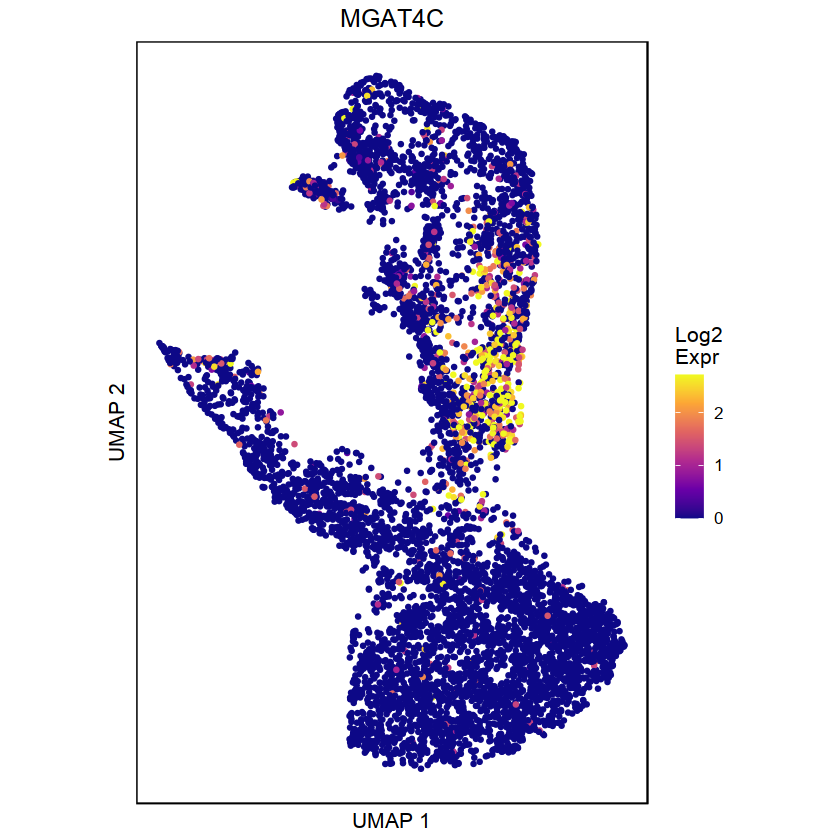

In [1061]:
options(repr.plot.width = 7, repr.plot.height = 7)

get_plot("MGAT4C")

In [83]:
table(atac_metaData_multiome_filt[atac_metaData_multiome_filt$sample=="D2M", "transfered_cluster"])


   2    3   11   13   15 
  22 1767  808  824  740 

In [110]:
GENE="COL1A1"
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] 0.8175369

[1] 0.8694299

[1] 1.825705

[1] 2.264284

In [145]:
mean_et_scaled = as.vector(colMeans(rna@assays$RNA@scale.data[et_genes, rna_bc_order]))
mean(mean_et_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(mean_et_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(mean_et_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(mean_et_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] 0.08172946

[1] 0.07360321

[1] -0.01715755

[1] -0.06962905

In [1030]:
mean_fibr_scaled = as.vector(colMeans(rna@assays$RNA@scale.data[fibr_genes, rna_bc_order]))
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] -0.07650123

[1] -0.05975318

[1] 0.009800309

[1] 0.04655874

In [253]:
cur = data.frame(val=as.vector(rna[['RNA']]["COL1A1", rna_bc_order]),
                  clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"]),
                  sample=atac_metaData_multiome_filt$sample,
                )
cur$isnonzero = cur$val >0 

cur %>% group_by(clst, sample) %>% summarize(frac_nonzero = mean(isnonzero), nonzero_mean=sum(val)/sum(isnonzero))

`summarise()` regrouping output by 'clst' (override with `.groups` argument)



clst                  sample frac_nonzero nonzero_mean
1  2 - Fibroblast-like   D1M    0.7709091    1.950009    
2  2 - Fibroblast-like   D2M    0.8936050    2.533876    
3  3 - Fibroblast-like   D1M    0.8333333    2.155094    
4  3 - Fibroblast-like   D2M    0.9545455    2.611342    
5  6 - Keratinocyte-like D1M    0.8115702    1.977390    
6  6 - Keratinocyte-like D2M    0.8179612    2.232020    
7  7 - Low OSK           D1M    0.5483193    1.702806    
8  7 - Low OSK           D2M    0.4459459    1.949631    
9  8 - High OSK          D1M    0.4874172    1.453804    
10 8 - High OSK          D2M    0.4344059    1.881965

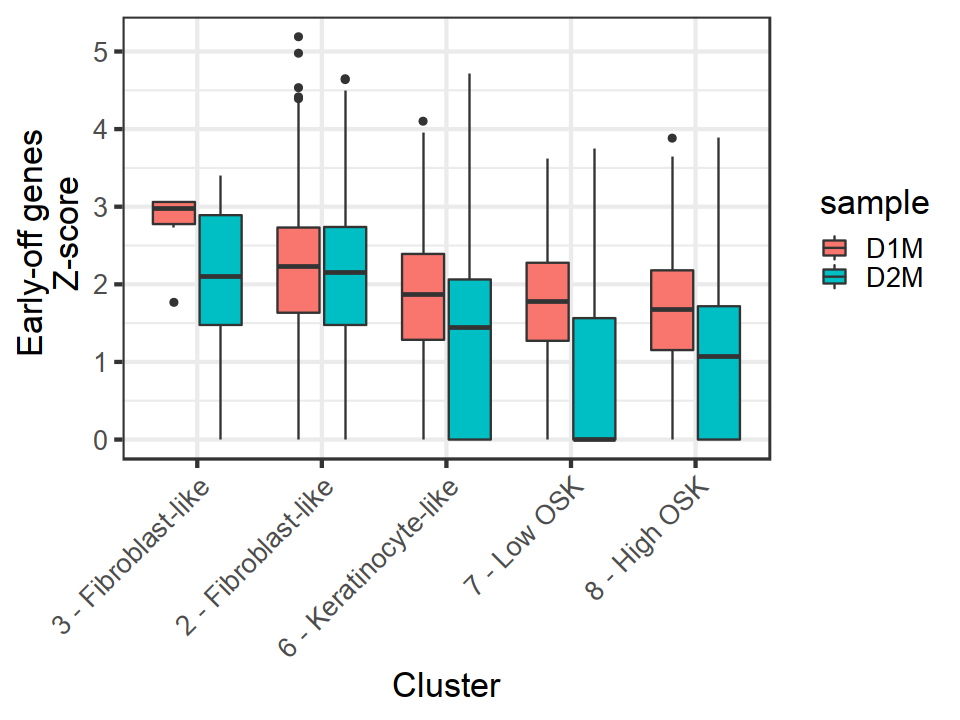

In [1046]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(data.frame(val=as.vector(rna[['RNA']]["FN1", rna_bc_order]),
                  clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"]),
                  sample=atac_metaData_multiome_filt$sample)) +
#            clst=paste(atac_metaData_multiome_filt$sample,
#                       atac_metaData_multiome_filt$transfered_cluster, sep='-'))) +
geom_boxplot(aes(x=factor(clst, levels=as.character(cluster_config[c(2,3,13,15,11), "label"])), 
                 y=val, fill=sample)) +
#            position=position_dodge(0.9)) +
xlab("Cluster") +
ylab("Early-off genes \n Z-score") +
theme_bw(base_size=20) +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

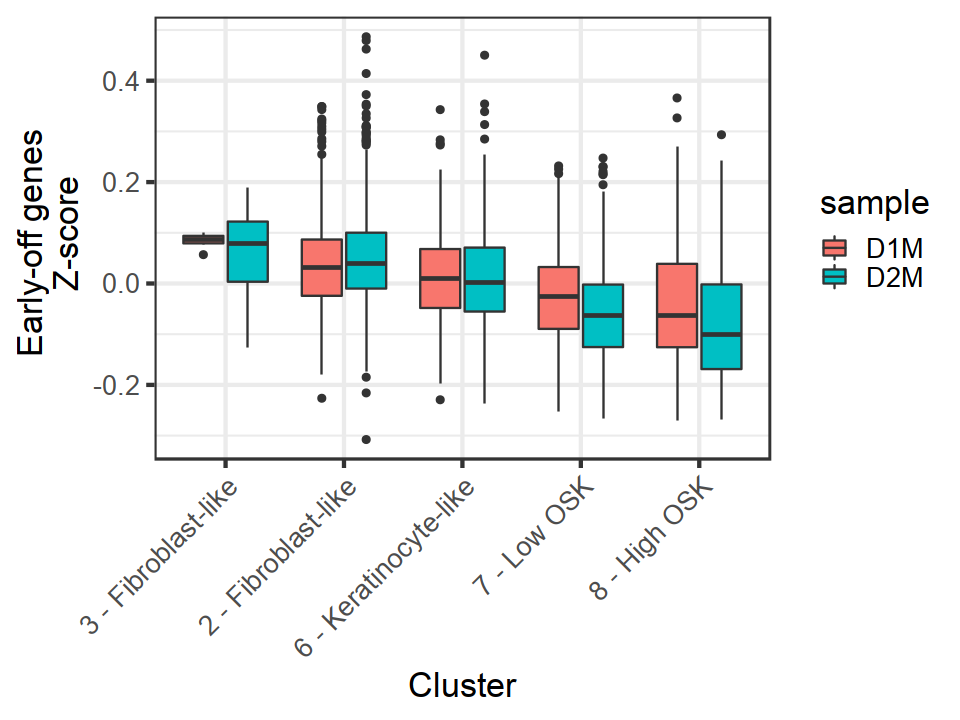

In [1032]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(data.frame(val=mean_fibr_scaled,
                  clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"]),
                  sample=atac_metaData_multiome_filt$sample)) +
#            clst=paste(atac_metaData_multiome_filt$sample,
#                       atac_metaData_multiome_filt$transfered_cluster, sep='-'))) +
geom_boxplot(aes(x=factor(clst, levels=as.character(cluster_config[c(2,3,13,15,11), "label"])), 
                 y=val, fill=sample)) +
#            position=position_dodge(0.9)) +
xlab("Cluster") +
ylab("Early-off genes \n Z-score") +
theme_bw(base_size=20) +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

In [1035]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D1M")&(atac_metaData_multiome_filt$transfered_cluster==11)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D1M") &     (atac_metaData_multiome_filt$transfered_cluster == 11)] and     (atac_metaData_multiome_filt$transfered_cluster == 11)]
W = 247284, p-value = 9.485e-11
alternative hypothesis: true location shift is not equal to 0


In [658]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &     (atac_metaData_multiome_filt$transfered_cluster == 11)] and     (atac_metaData_multiome_filt$transfered_cluster == 15)]
W = 261237, p-value = 1.756e-05
alternative hypothesis: true location shift is not equal to 0


In [281]:
head(atac_metaData_multiome_filt)

barcode                  TN    UM    PP    UQ   
D1M_AAAAAAAAAAACATGCTATTAGCC AAAAAAAAAAACATGCTATTAGCC  6736  6736  6736  6729
D1M_AAAAAAAAAAACATGCTCACCCTC AAAAAAAAAAACATGCTCACCCTC 28369 28369 28369 28339
D1M_AAAAAAAAAAACATGCTTGAGAAC AAAAAAAAAAACATGCTTGAGAAC 28635 28635 28635 28609
D1M_AAAAAAAAAAACCATGAACCTTGT AAAAAAAAAAACCATGAACCTTGT 33869 33869 33869 33838
D1M_AAAAAAAAAAACCATGAGCTTAAA AAAAAAAAAAACCATGAGCTTAAA 18885 18885 18885 18867
D1M_AAAAAAAAAAACCATGATATAGGC AAAAAAAAAAACCATGATATAGGC 12385 12385 12385 12370
                             CM   cluster umap1      umap2     sample
D1M_AAAAAAAAAAACATGCTATTAGCC  373 3       -0.4031222 -3.454888 D1M   
D1M_AAAAAAAAAAACATGCTCACCCTC 2447 5        2.6643078 -3.955240 D1M   
D1M_AAAAAAAAAAACATGCTTGAGAAC 2201 1       -0.2071755  2.688192 D1M   
D1M_AAAAAAAAAAACCATGAACCTTGT 3018 5        3.1269215 -4.609105 D1M   
D1M_AAAAAAAAAAACCATGAGCTTAAA 1514 1       -0.1988264  1.998739 D1M   
D1M_AAAAAAAAAAACCATGATATAGGC 1282 5        1.7942727 -3.712197 D1M   
                             cells                        transfered_cluster
D1M_AAAAAAAAAAACATGCTATTAGCC D1M_AAAAAAAAAAACATGCTATTAGCC  3                
D1M_AAAAAAAAAAACATGCTCACCCTC D1M_AAAAAAAAAAACATGCTCACCCTC  3                
D1M_AAAAAAAAAAACATGCTTGAGAAC D1M_AAAAAAAAAAACATGCTTGAGAAC 15                
D1M_AAAAAAAAAAACCATGAACCTTGT D1M_AAAAAAAAAAACCATGAACCTTGT  3                
D1M_AAAAAAAAAAACCATGAGCTTAAA D1M_AAAAAAAAAAACCATGAGCTTAAA 15                
D1M_AAAAAAAAAAACCATGATATAGGC D1M_AAAAAAAAAAACCATGATATAGGC  3

In [341]:
day_clst = factor(paste(atac_metaData_multiome_filt$sample, 
             atac_metaData_multiome_filt$transfered_cluster, sep='-'), 
       levels = c(paste("D1M", c(2,3,13,15,11), sep='-'), paste("D2M", c(2,3,13,15,11), sep='-')))
rna_tpm = as.matrix(rna@assays$RNA@counts[, rna_bc_order] %*% sparseMatrix(i=seq(ncol(rna)), j=as.integer(day_clst)))
colnames(rna_tpm) = levels(day_clst)
rna_tpm = 1e6*t(t(rna_tpm)/colSums(rna_tpm))

In [342]:
rna_tpm[c("COL1A1", "FN1", "JUN", "JUNB", "JUND", "FOS", "FOSL2", "FOSL1", "MAP2", "JAKMIP2", "KRT14", "KRT16", "HBA1"), ]

D1M-2      D1M-3        D1M-13      D1M-15      D1M-11      D2M-2     
COL1A1   676.52896  556.1031883 609.4479701 302.0453104 243.4274586 1393.64729
FN1     1578.56756 1081.9603062 744.8808523 642.3526944 617.7879726 1117.82126
JUN        0.00000   43.3350131  34.8367818  24.7578123  18.9973992   43.55148
JUNB       0.00000   12.5583099  20.3540748   9.9031249   6.1462174   14.51716
JUND      45.10193   17.8646380  23.4854709  16.6552556  11.9199368   58.06864
FOS        0.00000    0.3537552   0.3914245   0.4501420   0.9312451    0.00000
FOSL2     45.10193   36.7905417  36.7939044  24.7578123  25.3298656   43.55148
FOSL1    135.30579  241.9685628 236.8118317 142.6950274 106.1619368  159.68875
MAP2      45.10193   54.1245470  93.1590346 600.4894845 918.5801269   14.51716
JAKMIP2    0.00000   16.4496172  14.0912825  74.2734370  85.6745455    0.00000
KRT14      0.00000    0.3537552  23.8768954   0.0000000   2.9799842    0.00000
KRT16      0.00000    0.3537552   6.6542168   0.0000000   1.1174941    0.00000
HBA1       0.00000    1.0612656   9.7856129   0.9002841   3.5387312    0.00000
        D2M-3        D2M-13     D2M-15      D2M-11     
COL1A1  1356.7613871 854.171964 366.9970095  377.861615
FN1     1062.4910602 523.012695 282.7514134  401.122251
JUN       39.8574774  19.157974  16.0305385   15.342122
JUNB      15.1072697  15.052694   6.1393552    6.928700
JUND      24.2680608  36.400151  15.6894632   19.796286
FOS        0.1607156   0.821056   0.3410753    1.484721
FOSL2     33.4288520  36.947522  11.9376351   20.291193
FOSL1    200.2516807 131.368966 114.6012966   86.361299
MAP2      54.0004532 134.105819 402.8099146 1333.774791
JAKMIP2   30.3752549  55.558125 230.2258191  509.012012
KRT14      1.2857251  27.094849   0.0000000    2.969443
KRT16      0.3214313   3.010539   0.3410753    0.000000
HBA1       4.0178909  53.642328   3.7518282    9.403236

In [1048]:
length(fibr_genes)

[1] 1113

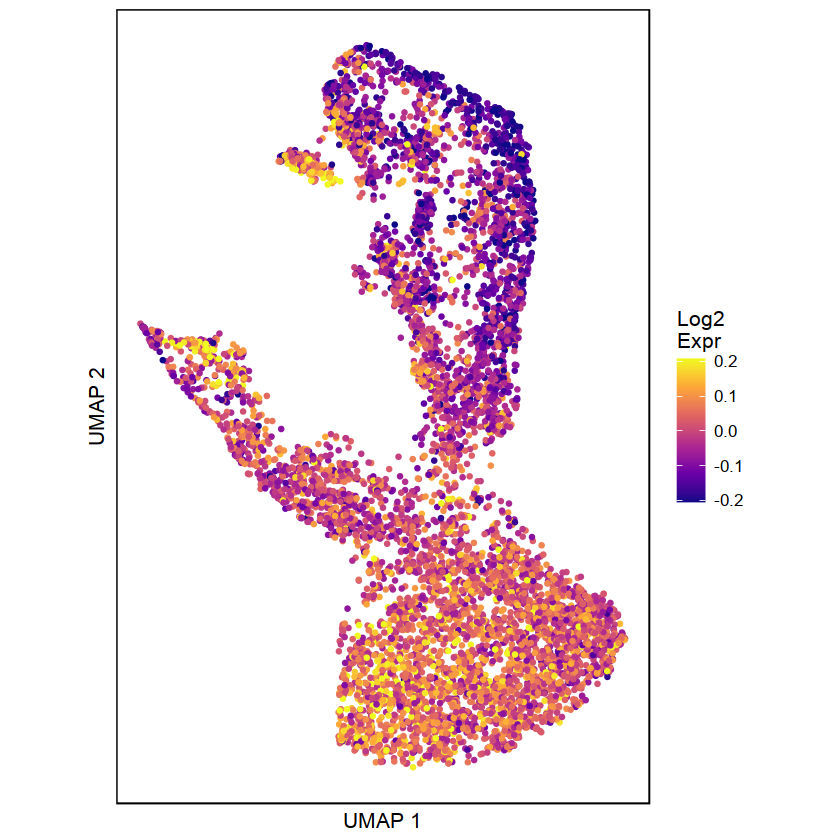

In [1050]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot_vals(mean_fibr_scaled) #, selection=atac_metaData_multiome_filt$sample=="D2M")

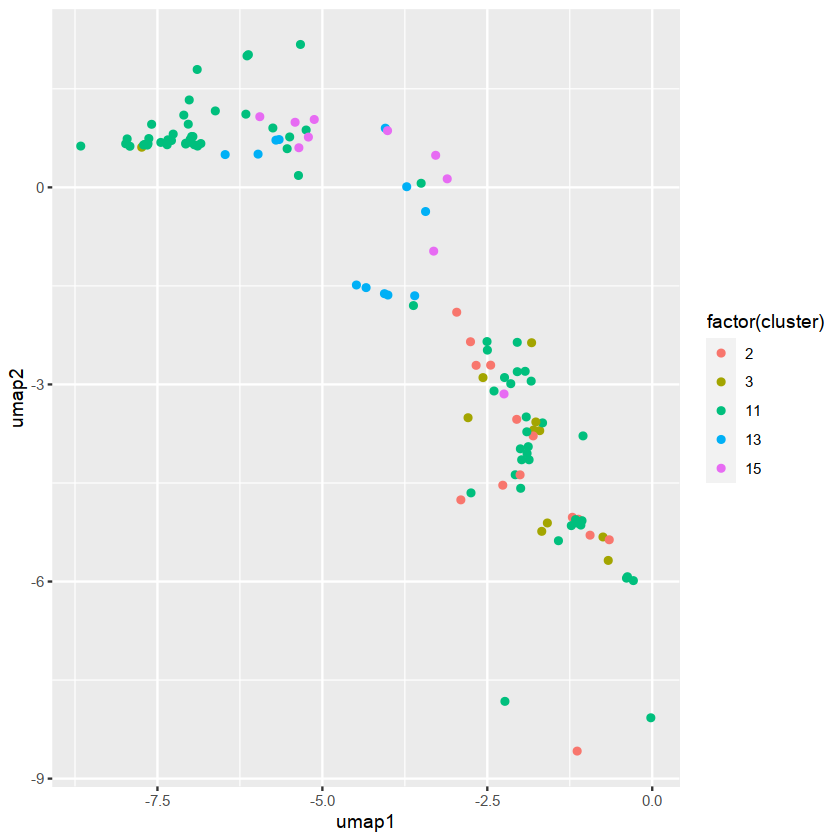

In [707]:
tmp = scatac_only_metaData[scatac_only_metaData$sample=="D2", ]
tmp$pass = tmp$barcode %in% lol$barcode
# tmp = tmp[order(tmp$pass),]
tmp = tmp[tmp$pass==T, ]

ggplot(tmp) +
geom_point(aes(x=umap1,y=umap2, col=factor(cluster)))

In [773]:
rna_mod = rna[, rna_bc_order]
rna_mod@meta.data$seurat_clusters = factor(ifelse((atac_metaData_multiome_filt$umap1 < -2)& (atac_metaData_multiome_filt$umap2 > 5) & 
                                                             (atac_metaData_multiome_filt$umap2 < 7.2), 2, 1))
rna_mod = SetIdent(rna_mod, value="seurat_clusters")
table(rna_mod@meta.data$seurat_clusters)


   1    2 
7219  159 

In [775]:
markers <- FindMarkers(rna_mod, ident.1 = 2, min.pct = 0.25)

In [777]:
mean(as.vector(rna_mod[["RNA"]]["SH3BGRL"])[rna_mod$seurat_clusters == 2] > 0)

[1] 0.3899371

In [776]:
head(markers)

p_val        avg_logFC  pct.1 pct.2 p_val_adj
SH3BGRL  1.473829e-05  0.2551940 0.390 0.250 0.4635486
GPATCH2L 8.050204e-05  0.3083819 0.547 0.425 1.0000000
PDE5A    2.523518e-04  0.2633991 0.610 0.449 1.0000000
MMP2     4.133584e-04 -0.2736486 0.170 0.296 1.0000000
SEMA6D   8.338148e-04  0.3534867 0.340 0.241 1.0000000
RNF19A   1.027458e-03  0.3021213 0.352 0.249 1.0000000

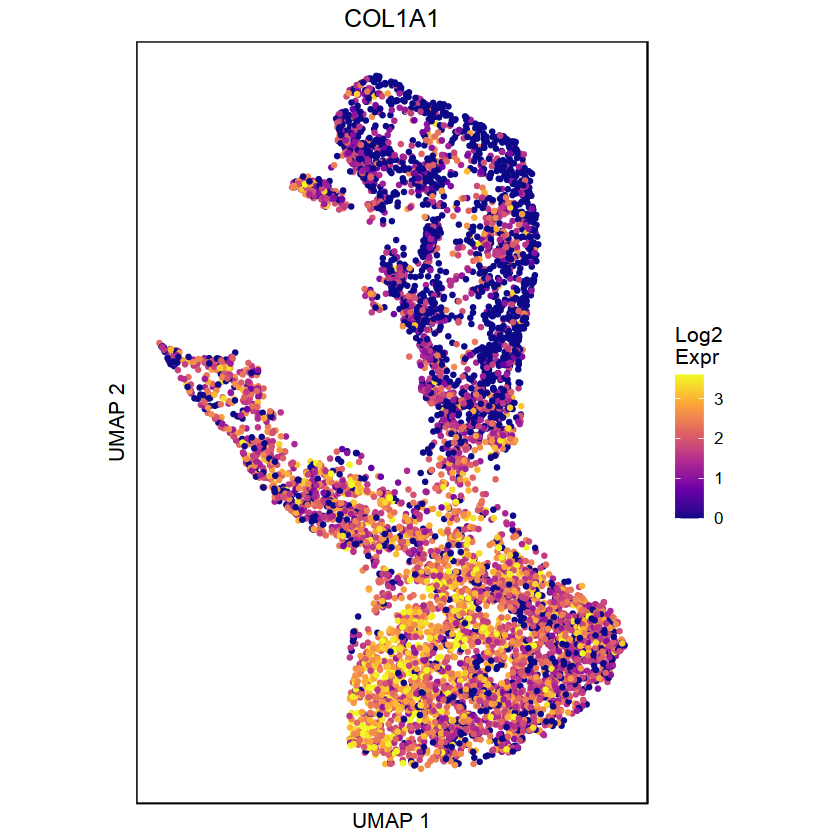

In [1044]:
options(repr.plot.width = 7, repr.plot.height = 7)

get_plot("COL1A1")

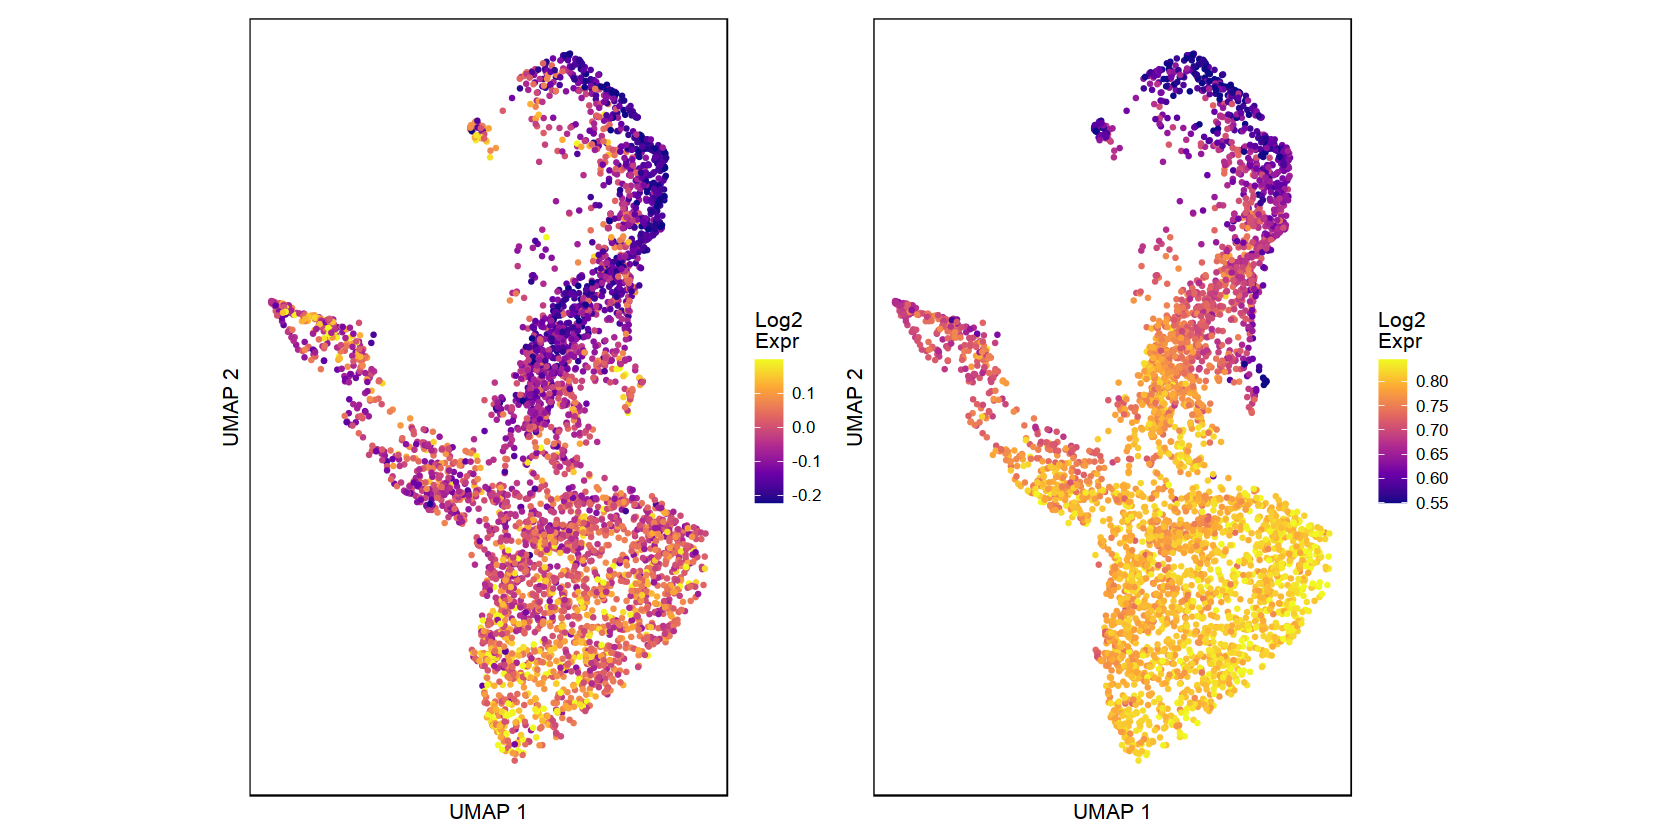

In [524]:
options(repr.plot.width = 14, repr.plot.height = 7)
selection = (atac_metaData_multiome_filt$sample=="D2M")#&(atac_metaData_multiome_filt$cluster %in% c(2,5,6))
vals=mean_fibr_scaled[selection]
df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=-atac_metaData_multiome_filt$umap2[selection],
                    expr=vals)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

p1 = ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, 0.02),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()  

vals=norm_fibr_multiome[selection]
df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=-atac_metaData_multiome_filt$umap2[selection],
                    expr=vals)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

p2 = ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, 0.02),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()  

p1 | p2

In [42]:
rsums = Matrix::rowSums(atac_bmat)

In [43]:
pmat_rsums = Matrix::rowSums(atac_pmat)

In [353]:
pmat_peak_sums = Matrix::colSums(atac_pmat)

In [359]:
dim(atac_pmat)

[1]  13525 530910

In [442]:
which.max(pmat_peak_sums)

[1] 46077

In [447]:
atac_peaks[2647]

GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]    chr17 33596352-33596853      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [446]:
head((order(pmat_peak_sums)))

[1]  2647  6227  8992 20084 20492 21544

In [385]:
pmat_bc_high_peaks_sums = Matrix::rowSums(atac_pmat[, head(rev(order(pmat_peak_sums)), 20000)])

In [457]:
min(pmat_bc_high_peaks_sums)

[1] 85

In [497]:
write.table(data.frame(atac_peaks[head(rev(order(pmat_peak_sums)), 20000)]), "~/tmp/lol.bed", sep='\t', row.names=F, quote=F, col.names=F)

In [44]:
rsums[1:5]

[1]  6895 27498 28014 32469 18605

In [45]:
cor(pmat_rsums, rsums)

[1] 0.9889691

[1] 0.2611137

5% 
0.5283559

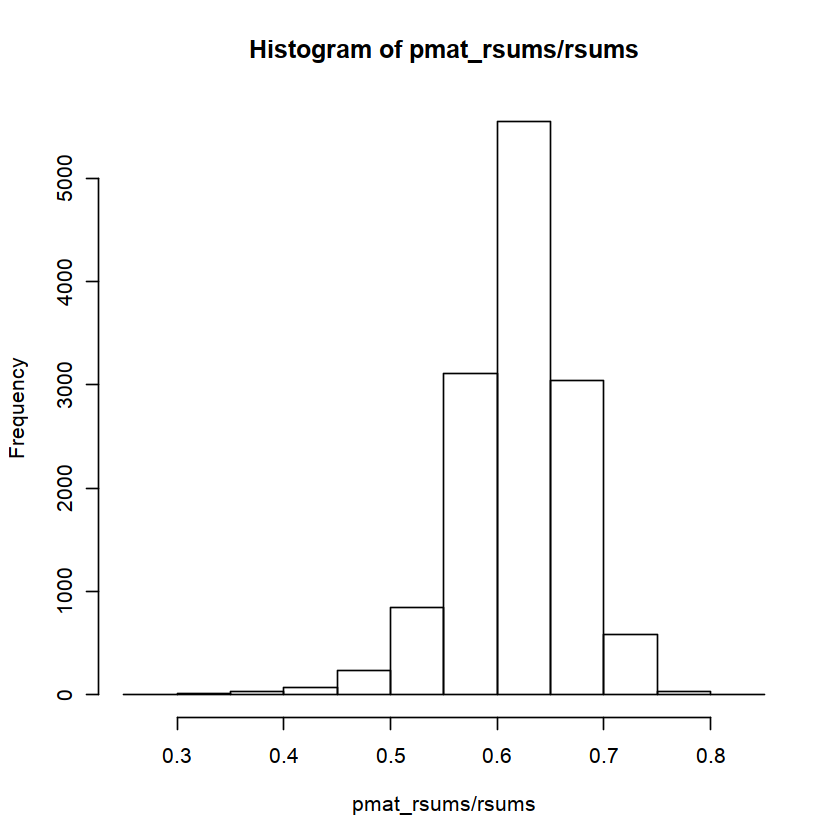

In [46]:
min(pmat_rsums/rsums)
quantile(pmat_rsums/rsums, .05)
hist(pmat_rsums/rsums)

In [47]:
reads_in_fibr_peaks_bmat = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, fibroblast_peaks)))])
reads_in_fibr_peaks_pmat = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, fibroblast_peaks)))])

In [346]:
reads_in_et1_peaks_bmat = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, et1_peaks)))])
reads_in_et1_peaks_pmat = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, et1_peaks)))])

In [48]:
reads_in_ap1_not_fibr_peaks_bmat = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, ap1_not_fibr_hits)))])
reads_in_ap1_not_fibr_peaks_pmat = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, ap1_not_fibr_hits)))])

In [49]:
reads_in_all_peaks_bmat = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, all_peaks)))])

In [50]:
norm_fibr_multiome_bmat = (reads_in_fibr_peaks_bmat/reads_in_all_peaks_bmat)[atac_metaData$sample!="D2"]

In [960]:
tmp_peakset = import("~/tmp/D1M.c11.exclusive.bed")
tmp_peakset

reads_tmp_peakset = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, tmp_peakset)))])

GRanges object with 27657 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]     chr1 100012932-100013226      *
      [2]     chr1 100040030-100040550      *
      [3]     chr1 100073423-100073628      *
      [4]     chr1 100085486-100085876      *
      [5]     chr1 100145089-100145502      *
      ...      ...                 ...    ...
  [27653]     chrY     7343226-7343804      *
  [27654]     chrY     7343226-7343804      *
  [27655]     chrY     7501381-7501654      *
  [27656]     chrY     7760581-7761121      *
  [27657]     chrY     7961939-7962140      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

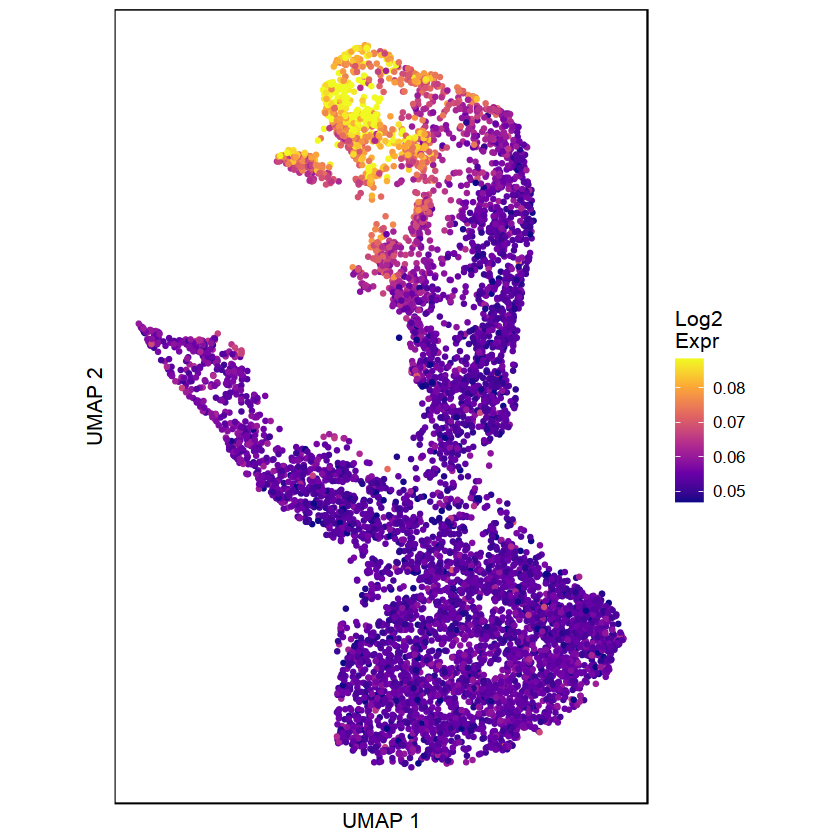

In [961]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_tmp_peakset/rsums)[atac_metaData$sample!="D2"])

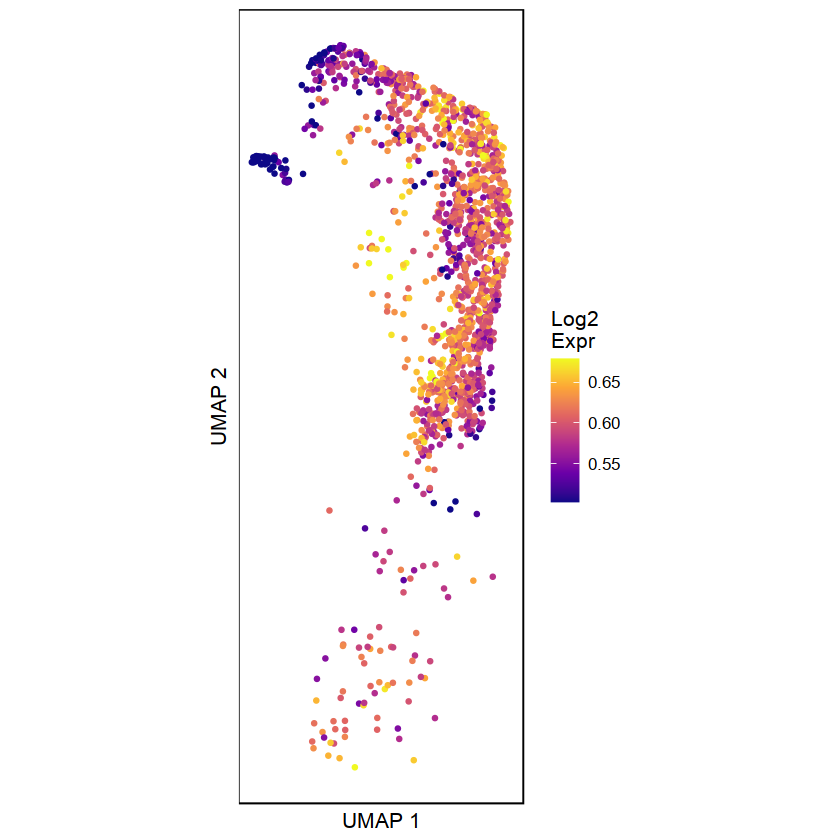

In [642]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((pmat_rsums/rsums)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(11,15)),)

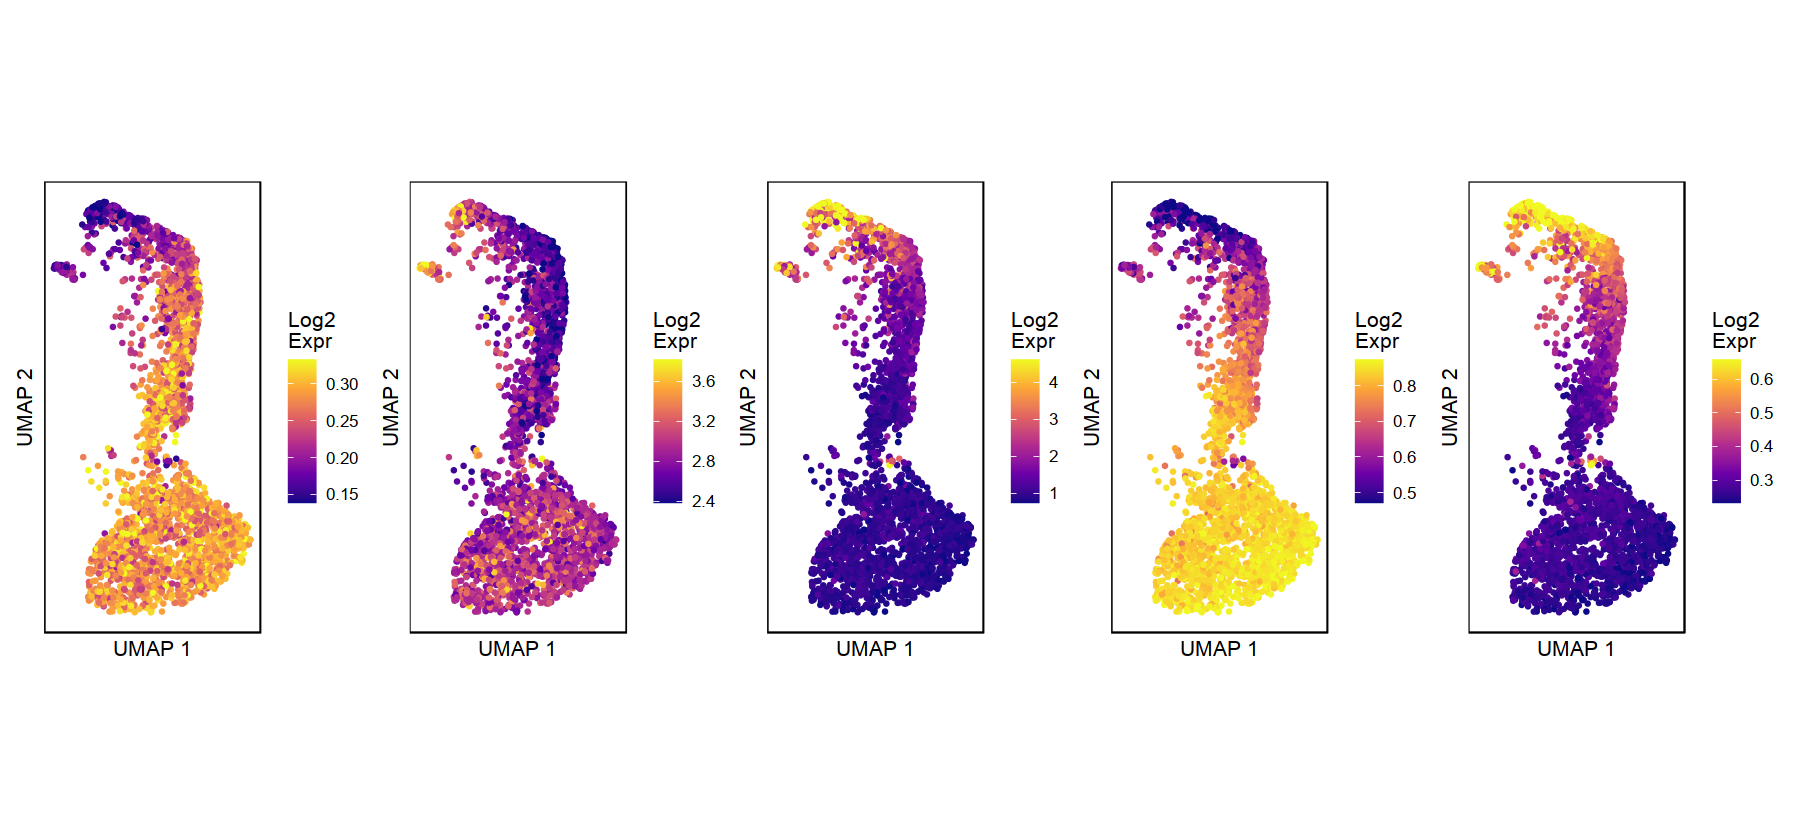

In [654]:
options(repr.plot.width =15 , repr.plot.height = 7)
plot_vals((pmat_bc_high_peaks_first10k/pmat_rsums)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(3,11,15))) | 
plot_vals((reads_in_fibr_peaks_pmat/pmat_bc_high_peaks_first10k)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(3,11,15)))  | 
plot_vals((reads_tmp_peakset/pmat_bc_high_peaks_first10k)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(3,11,15))) |
plot_vals((reads_in_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(3,11,15)))  | 
plot_vals((reads_tmp_peakset/pmat_rsums)[atac_metaData$sample!="D2"],
         selection=(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$ transfered_cluster %in% c(3,11,15)))

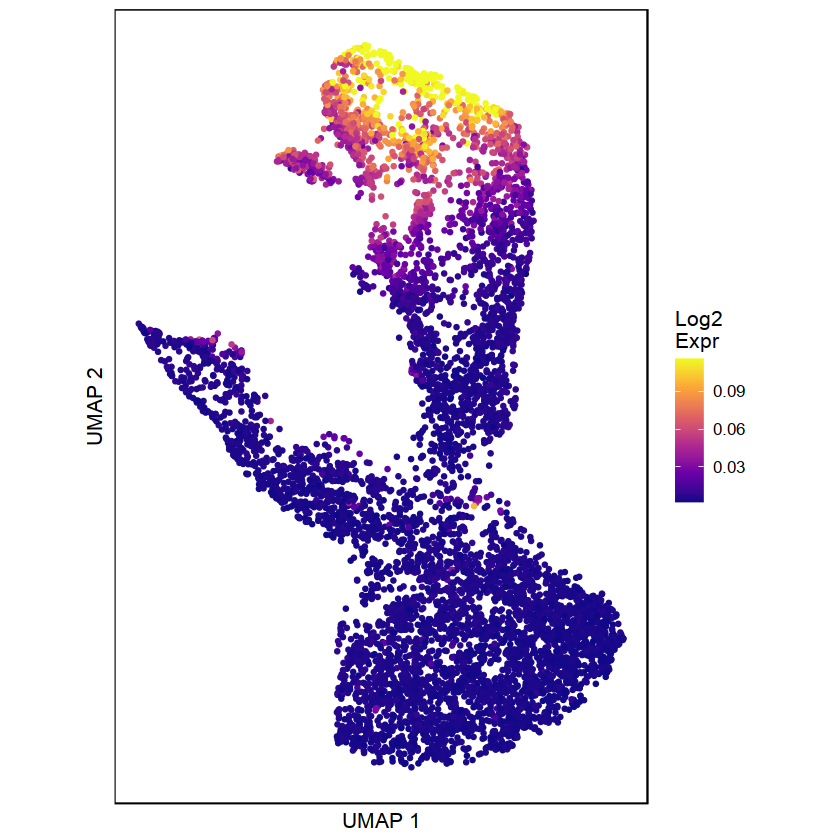

In [519]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_in_et1_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"])

**Correlations between scATAC and multiome**

In [524]:
d2_c11_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2")&(atac_metaData$transfered_cluster==11), ])
d2m_c11_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2M")&(atac_metaData$transfered_cluster==11), ])

In [529]:
d2_c15_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2")&(atac_metaData$transfered_cluster==15), ])
d2m_c15_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2M")&(atac_metaData$transfered_cluster==15), ])

d2_c3_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2")&(atac_metaData$transfered_cluster==3), ])
d2m_c3_sums = Matrix::colSums(atac_pmat[(atac_metaData$sample=="D2M")&(atac_metaData$transfered_cluster==3), ])

In [531]:
cor(log2(1+d2_c11_sums), log2(1+d2m_c11_sums), method='spearman')

[1] 0.8744379

In [536]:
cor(log2(1+d2_c11_sums), log2(1+d2_c15_sums), method='spearman')
cor(log2(1+d2_c11_sums), log2(1+d2_c3_sums), method='spearman')

[1] 0.6501036

[1] 0.4364919

In [537]:
cor(log2(1+d2m_c11_sums), log2(1+d2m_c15_sums), method='spearman')

[1] 0.6544218

In [534]:
cor(log2(1+d2_c15_sums), log2(1+d2m_c15_sums), method='spearman')

[1] 0.77115

In [535]:
cor(log2(1+d2_c3_sums), log2(1+d2m_c3_sums), method='spearman')

[1] 0.8238785

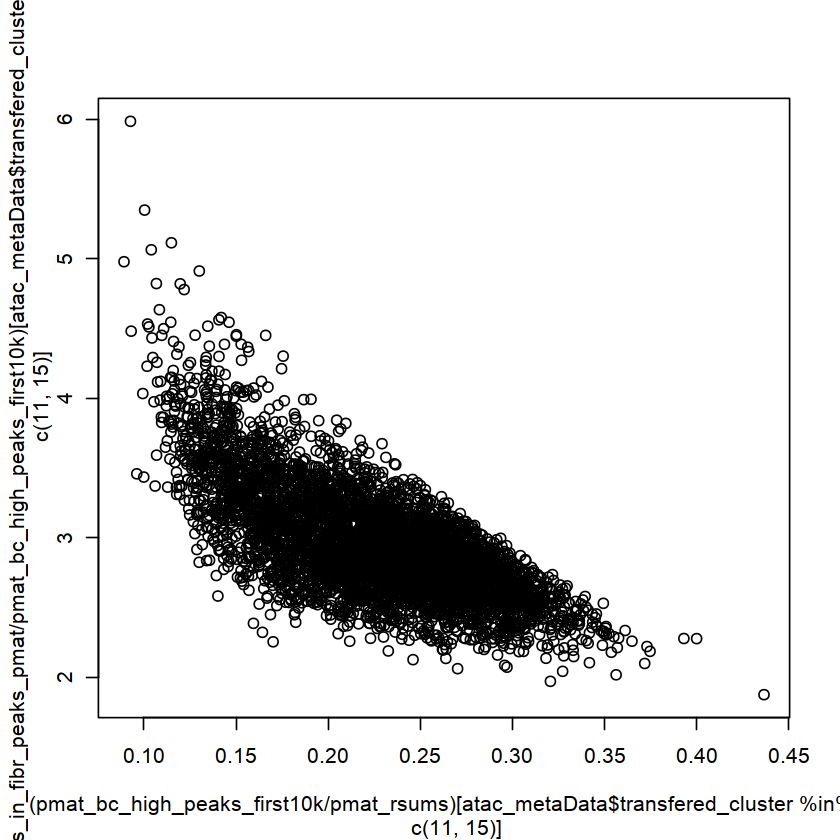

In [544]:
plot((pmat_bc_high_peaks_first10k/pmat_rsums)[atac_metaData$transfered_cluster %in% c(11,15)],
   (reads_in_fibr_peaks_pmat/pmat_bc_high_peaks_first10k)[atac_metaData$transfered_cluster %in% c(11,15)])

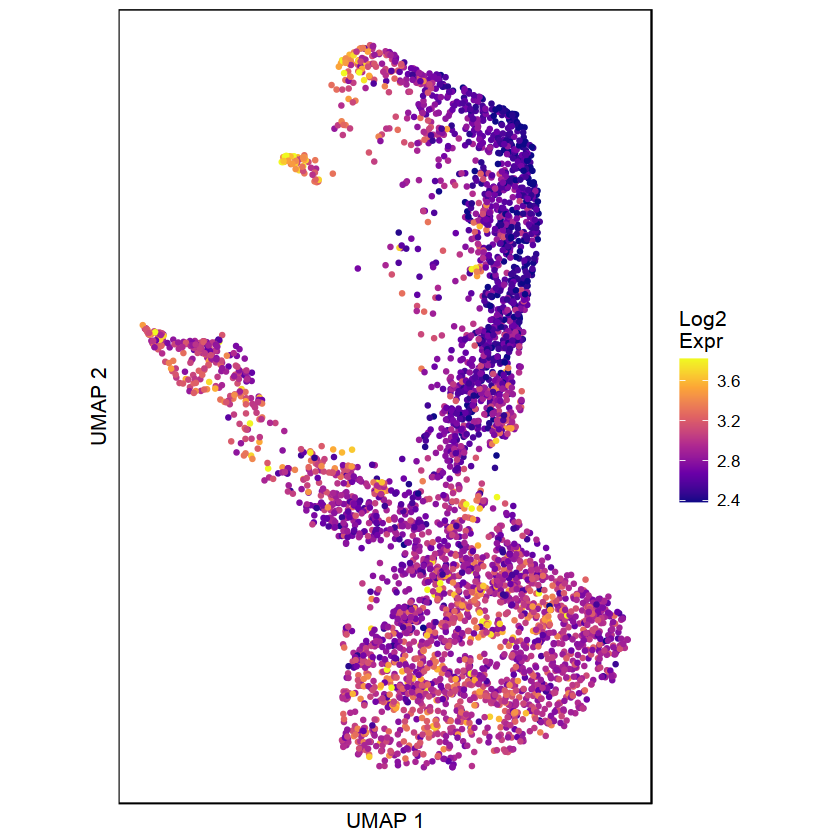

In [563]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_in_fibr_peaks_pmat/pmat_bc_high_peaks_first10k)[atac_metaData$sample!="D2"], 
          selection=atac_metaData_multiome_filt$sample=="D2M")

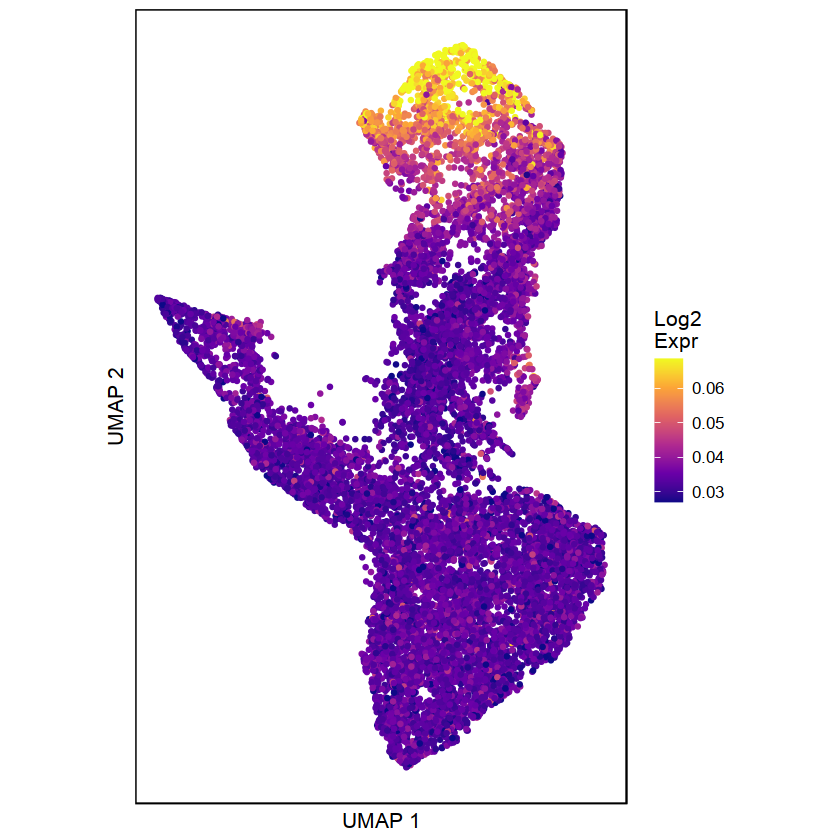

In [585]:
options(repr.plot.width =7 , repr.plot.height = 7)
selection = (atac_metaData$sample!="D1")#&(atac_metaData_multiome_filt$cluster %in% c(2,5,6))
vals=(reads_tmp_peakset/reads_in_all_peaks)[selection]
df = data.frame(umap1=atac_metaData$umap1[selection], 
                    umap2=-atac_metaData$umap2[selection],
                    expr=vals)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, 0.02),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()  

vals=norm_fibr_multiome[selection]
df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=-atac_metaData_multiome_filt$umap2[selection],
                    expr=vals)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

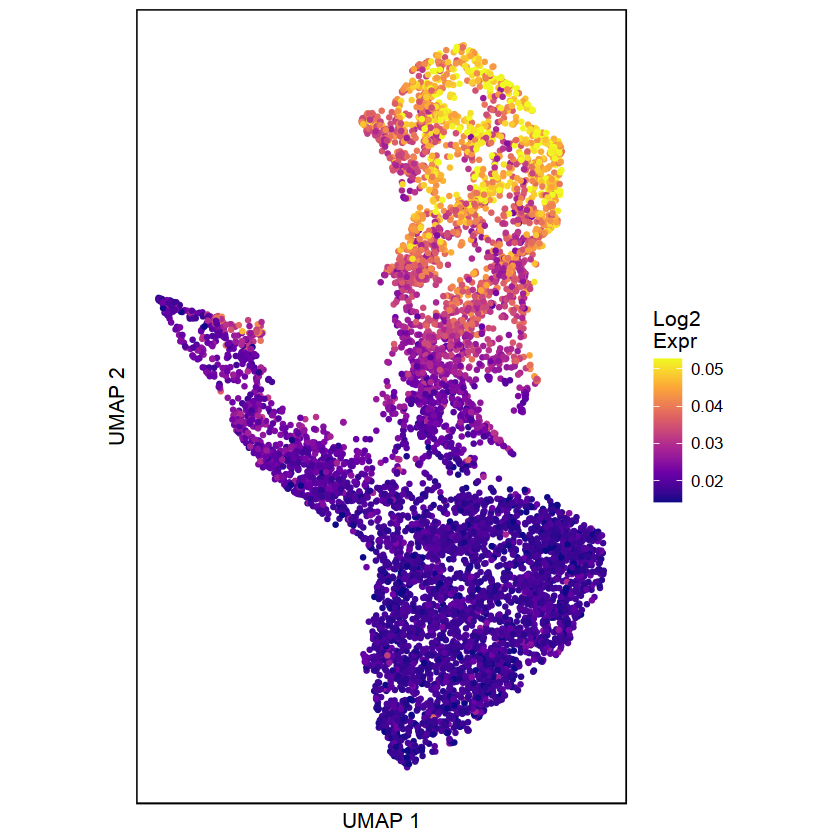

In [479]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_in_ap1_not_fibr_peaks/reads_in_all_peaks)[atac_metaData$sample!="D2"])

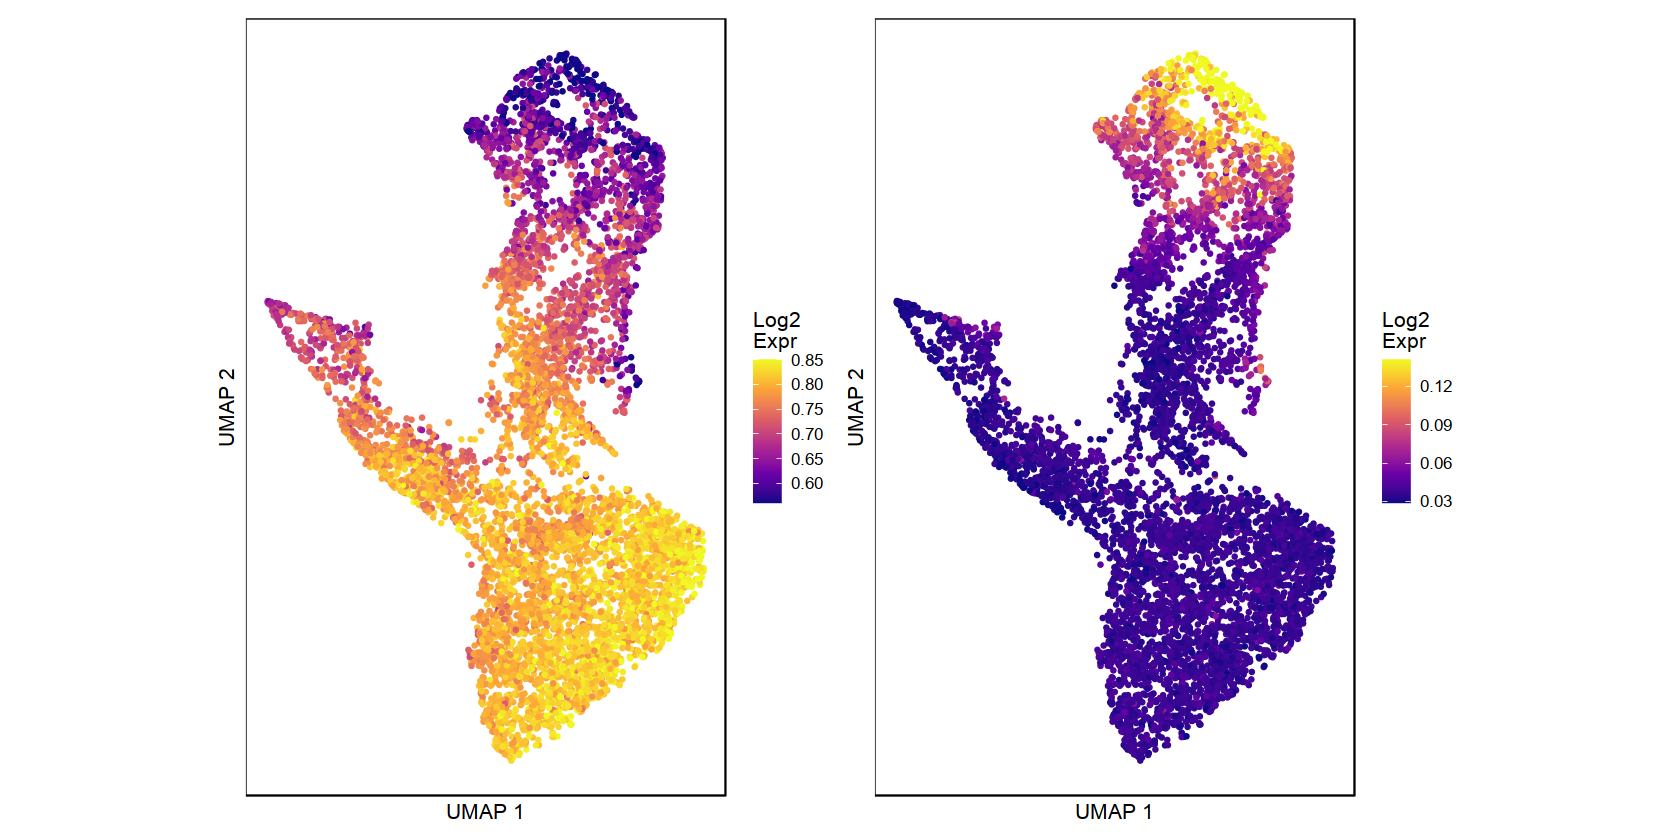

In [420]:
options(repr.plot.width = 14, repr.plot.height = 7)
plot_vals(norm_fibr_multiome) | plot_vals((reads_in_et1_peaks/reads_in_all_peaks)[atac_metaData$sample!="D2"])

In [318]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$cluster%in% c(2,5,6,8))
gene_corrs = cor(norm_fibr_multiome[selection], as.matrix(t(rna[['RNA']][, rna_bc_order][, selection])), method='spearman')
gene_corrs_wo_na = gene_corrs[!is.na(gene_corrs)]
names(gene_corrs_wo_na) = colnames(gene_corrs)[!is.na(gene_corrs)]

Warning message in cor(norm_fibr_multiome[selection], as.matrix(t(rna[["RNA"]][, :
“the standard deviation is zero”


In [319]:
# rna[['RNA']][, rna_bc_order][, selection]

In [342]:
null_corrs = c()

exprs = as.vector(rna[["RNA"]]["COL1A1", rna_bc_order])[selection]
for (i in seq(1000)) {
    null_corrs = c(null_corrs, 
                   cor(norm_fibr_multiome[selection], 
                       sample(exprs), method='spearman'))
}

In [343]:
cor(norm_fibr_multiome[selection], exprs, method='spearman')

[1] 0.2814084

In [344]:
mean(null_corrs > cor(norm_fibr_multiome[selection], exprs, method='spearman'))

[1] 0

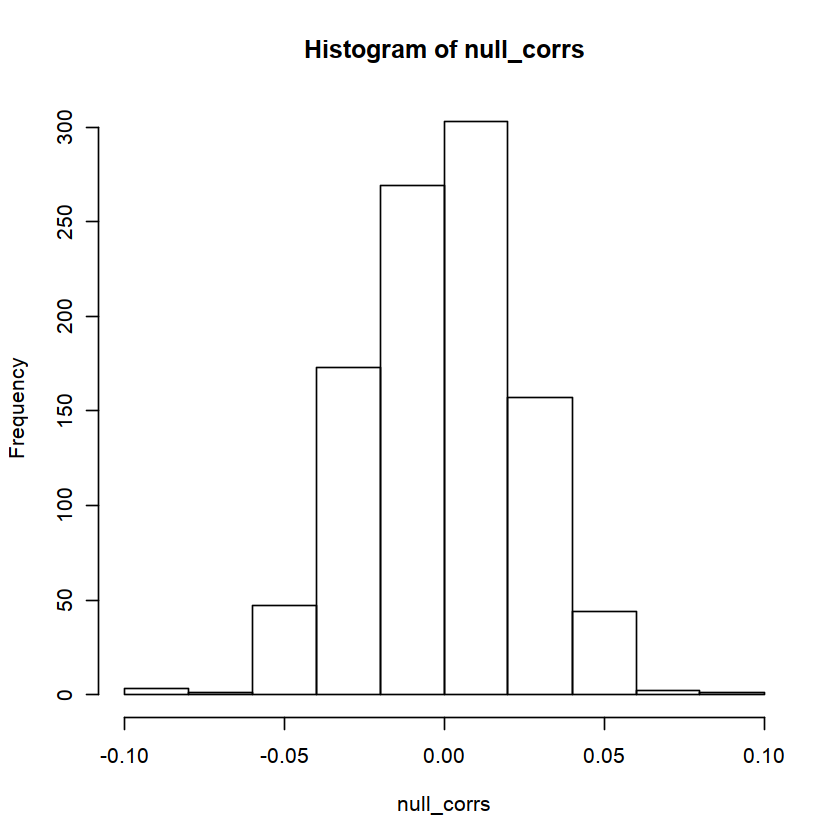

In [345]:
hist(null_corrs)

In [306]:
mean(as.vector(rna[["RNA"]]["FOSL2", rna_bc_order])[selection] > 0)

[1] 0.0876023

In [295]:
gene_corrs_wo_na[c("JUN","JUNB","JUND","FOS","FOSL1","FOSL2")]

JUN          JUNB          JUND           FOS         FOSL1 
 0.1047524583  0.0001043667 -0.0184669721 -0.0360041837  0.2486417191 
        FOSL2 
 0.0467926166

In [293]:
gene_corrs_wo_na[c("JUN","JUNB","JUND","FOS","FOSL1","FOSL2")]

JUN         JUNB         JUND          FOS        FOSL1        FOSL2 
 0.057930038  0.004903471 -0.018632796 -0.029045711  0.159426837 -0.023031849

In [296]:
gene_corrs_wo_na[gene_corrs_wo_na>0.2]

HMGN2      RAB3B       NEXN       DPYD     NUCKS1      CENPF      CAPN2 
 0.2635821  0.2902383  0.2589377  0.2063193  0.2208366  0.2155003  0.2465314 
      FMN2       PXDN      LTBP1      CRIM1   CDC42EP3     SLC8A1      CALM2 
 0.2771448  0.2787727  0.2434458  0.3904091  0.2562778  0.2503901  0.2557869 
      RTN4     TMSB10       AFF3       RFX8     SH3RF3       RND3        FAP 
 0.3854186  0.2685343  0.2581689  0.2872743  0.2469836  0.3344910  0.2094110 
     SCN9A       TFPI    SPATS2L        FN1     DOCK10       PTMA     COL6A3 
 0.2210534  0.2052200  0.2324818  0.3904079  0.2398931  0.3065415  0.5490682 
   ANKRD28      RBMS3     DCBLD2    NECTIN3     CCDC80     ZBTB38     TM4SF1 
 0.2305048  0.2465021  0.4509119  0.2177208  0.2274754  0.3070938  0.2306954 
     NCEH1        LPP     PDGFRA     ANTXR2       FGF5    CFAP299      DCLK2 
 0.2375183  0.2494397  0.2181257  0.2194692  0.4240090  0.2827227  0.2139889 
     VEGFC       TRIO      MYO10      ITGA2      IL6ST    ADAMTS6      RASA1 
 0.3776279  0.3729072  0.4211804  0.3382204  0.2469251  0.3203687  0.2184923 
      RGMB      PRR16     ABLIM3      SPARC    INSYN2B       TUBB      HMGA1 
 0.2129823  0.3068812  0.2252307  0.2409132  0.2012007  0.2357423  0.2165417 
    EEF1A1    COL12A1       NT5E     MARCKS      SYNJ2       ACTB       ANLN 
 0.2153725  0.2050871  0.3267357  0.2887799  0.2313386  0.4937441  0.2297869 
     INHBA       EGFR     SEMA3A     COL1A2   SERPINE1       CAV1      CPED1 
 0.3804259  0.2966766  0.3382621  0.4188768  0.2495250  0.2029558  0.3262724 
      CALU AC016831.7  LINC00513      CALD1 AC009264.1      CHRM2      HIPK2 
 0.3599757  0.2007003  0.3333620  0.2760243  0.2067983  0.2478929  0.2582353 
      DLC1      LOXL2      SFRP1       ASPH       EXT1       HAS2       BNC2 
 0.3339218  0.2315341  0.2461411  0.4642615  0.3887800  0.2692159  0.3828185 
   MIR31HG        TNC       KLF6        VIM       ZEB1      ITGB1       NRP1 
 0.2664205  0.2127011  0.2195609  0.4530655  0.3627726  0.4201631  0.4417403 
  ARHGAP22       PLAU     KCNMA1     MICAL2      TEAD1       CD44      AHNAK 
 0.2181308  0.2506166  0.2308909  0.2218387  0.3053769  0.3707218  0.3502671 
      ATL3     MALAT1      FOSL1      CCND1      BIRC2       MMP1      TAGLN 
 0.2127866  0.4259293  0.2486417  0.2640668  0.2089710  0.2518534  0.2004022 
  MIR100HG       ETS1        NTM      GAPDH    SLC38A2       CBX5     SRGAP1 
 0.4142673  0.2053549  0.3496016  0.2090729  0.2887295  0.2162699  0.3130737 
     HMGA2  HMGA2-AS1      TRHDE     PHLDA1       E2F7       NAV3     TXNRD1 
 0.3629313  0.2826734  0.4057830  0.2877763  0.2021624  0.3150392  0.2693199 
     CKAP4     CORO1C     MED13L      HMGB1      FRMD6    ZFP36L1      ACTN1 
 0.3159172  0.2075115  0.2173975  0.3119467  0.4117036  0.2862093  0.2325063 
     LTBP2      GREM1       FMN1      THBS1     GPR176       TPM1      SMAD3 
 0.2001322  0.5381277  0.3393446  0.3233814  0.2381949  0.3212890  0.3706149 
      UACA        PKM      NR2F2       MT2A       NQO1      CDH13     CAVIN1 
 0.4570827  0.2043139  0.2618031  0.3075527  0.2513921  0.3652400  0.2073960 
    COL1A1      TANC2     SMURF2      PRKCA      ACTG1        DCC       TPM4 
 0.4552649  0.2028391  0.4768818  0.3048434  0.2685862  0.2312049  0.3702005 
       AXL     COL6A2       MYH9     LGALS1   MIR222HG       FLNA 
 0.4365800  0.2210896  0.3293013  0.4021726  0.2972019  0.2158336

In [155]:
(names(gene_corrs)[gene_corrs>0.2])

ERROR: Error in eval(expr, envir, enclos): object 'gene_corrs' not found


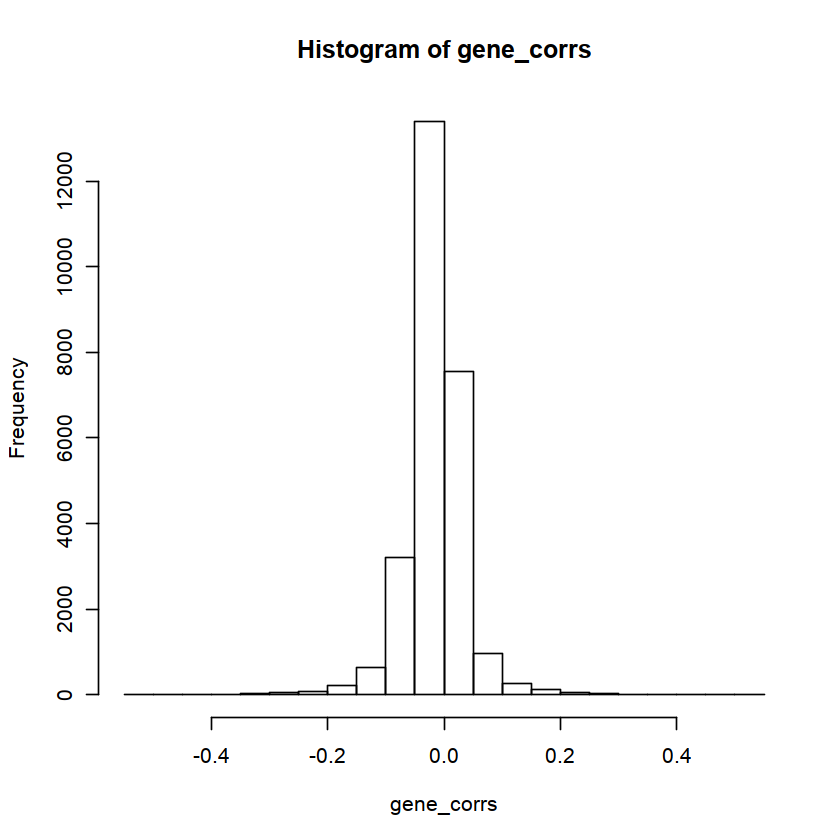

In [266]:
hist(gene_corrs)

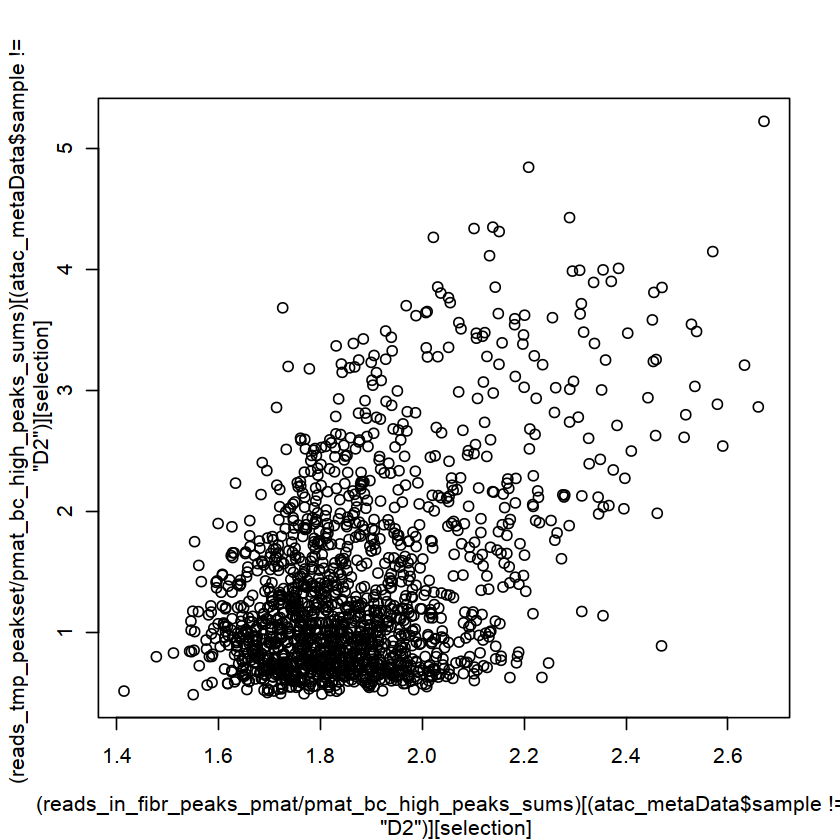

In [573]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
plot((reads_in_fibr_peaks_pmat/pmat_bc_high_peaks_sums)[(atac_metaData$sample!="D2")][selection], 
    (reads_tmp_peakset/pmat_bc_high_peaks_sums)[(atac_metaData$sample!="D2")][selection])

In [154]:
selection = (atac_metaData_multiome_filt$sample %in% c("D1M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
cor(norm_fibr_multiome_bmat[selection], mean_et_scaled[selection], method='spearman')

[1] -0.2627749

In [490]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$cluster%in% c(2,5,6,8))
cor(norm_fibr_multiome[selection], mean_fibr_scaled[selection], method='spearman')

[1] 0.3618233

In [61]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
cor((reads_in_ap1_not_fibr_peaks_bmat/reads_in_all_peaks_bmat)[atac_metaData$sample!="D2"][selection], mean_fibr_scaled[selection], method='spearman')

[1] -0.532532

In [1042]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
cor((reads_in_ap1_not_fibr_peaks_bmat/reads_in_all_peaks_bmat)[atac_metaData$sample!="D2"][selection], mean_fibr_scaled[selection], method='spearman')

[1] -0.5122751

In [141]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
cor((reads_in_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection], mean_fibr_scaled[selection], method='spearman')

[1] 0.4306904

In [648]:
selection = (atac_metaData_multiome_filt$sample %in% c("D2M"))&(atac_metaData_multiome_filt$transfered_cluster%in% c(11,15))
cor((reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection], as.vector(rna[['RNA']]["COL1A1", rna_bc_order])[selection], method='spearman')

[1] -0.4648045

`geom_smooth()` using formula 'y ~ x'



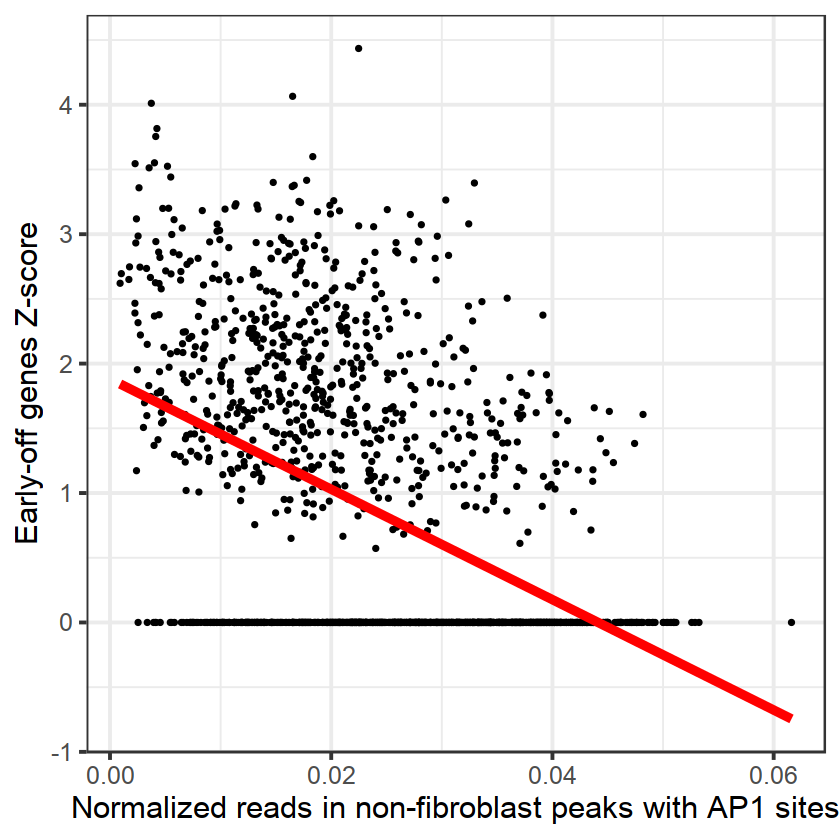

In [277]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data.frame(non_fibr_frac=((reads_in_ap1_not_fibr_peaks_pmat/pmat_rsums)[atac_metaData$sample!="D2"][selection]), 
                  norm_fibr_expr=as.vector(rna[['RNA']]["COL1A1", rna_bc_order])[selection]),
      aes(x=non_fibr_frac, y=norm_fibr_expr)) +
geom_point(size=1) + 
geom_smooth(method = "lm", se = FALSE, color='red',size=2) + 
xlab("Normalized reads in non-fibroblast peaks with AP1 sites") + 
ylab("Early-off genes Z-score") +
theme_bw(base_size=18) 

`geom_smooth()` using formula 'y ~ x'



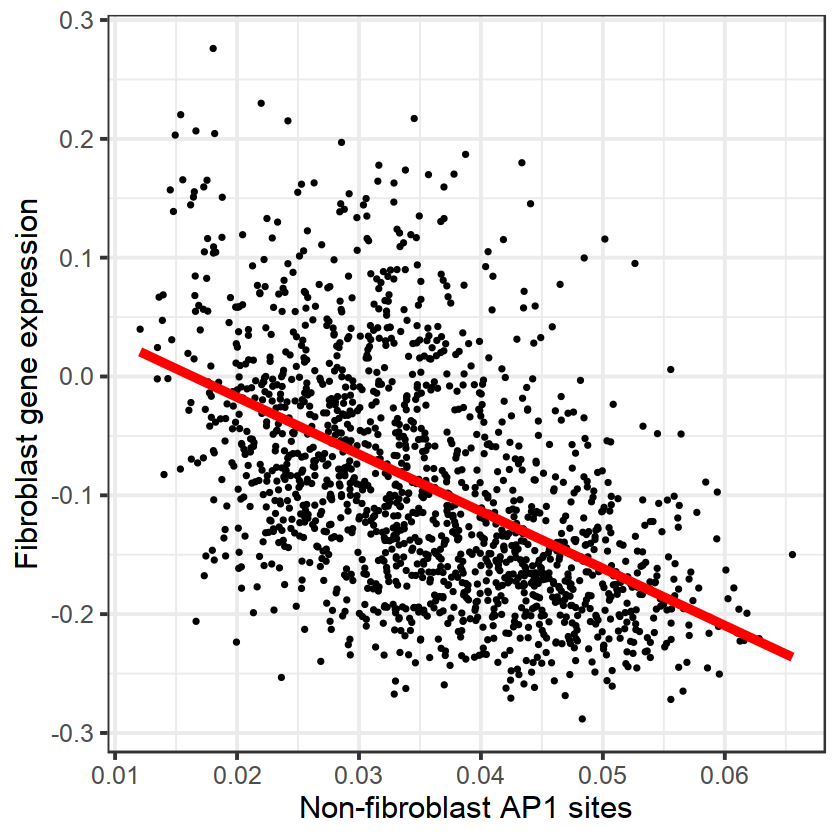

In [63]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data.frame(non_fibr_frac=((reads_in_ap1_not_fibr_peaks_bmat/reads_in_all_peaks_bmat)[atac_metaData$sample!="D2"][selection]), 
                  norm_fibr_expr=mean_fibr_scaled[selection]),
      aes(x=non_fibr_frac, y=norm_fibr_expr)) +
geom_point(size=1) + 
geom_smooth(method = "lm", se = FALSE, color='red',size=2) + 
xlab("Non-fibroblast AP1 sites") + 
ylab("Fibroblast gene expression") +
theme_bw(base_size=18) 

`geom_smooth()` using formula 'y ~ x'



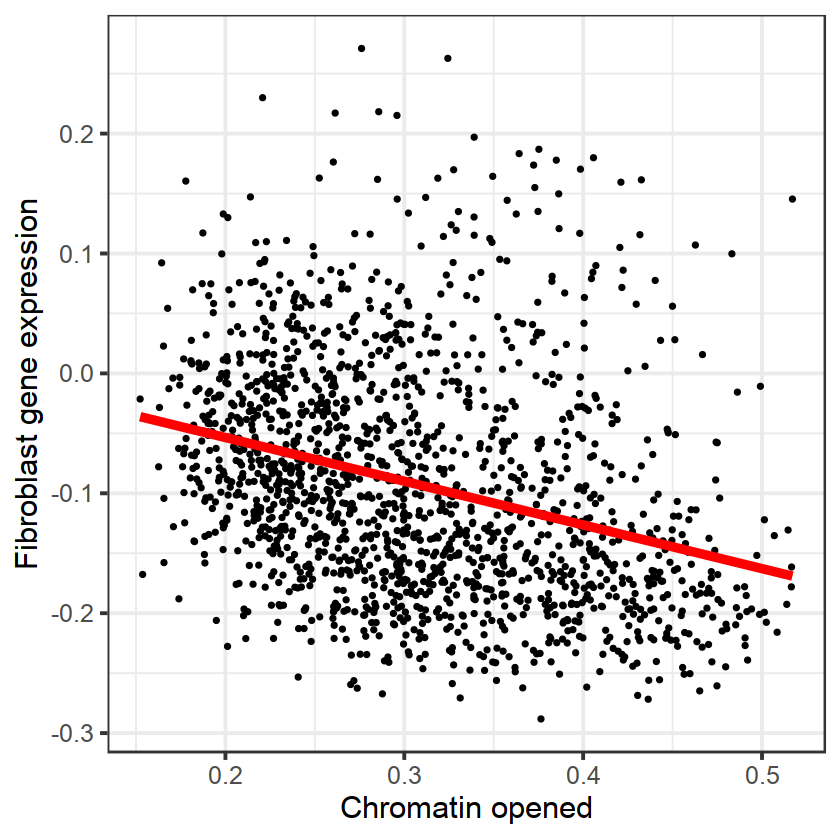

In [435]:
ggplot(data.frame(non_fibr_frac=(1-norm_fibr_multiome[selection]), 
                  norm_fibr_expr=mean_fibr_scaled[selection]),
      aes(x=non_fibr_frac, y=norm_fibr_expr)) +
geom_point(size=1) + 
geom_smooth(method = "lm", se = FALSE, color='red',size=2) + 
xlab("Chromatin opened") + 
ylab("Fibroblast gene expression") +
theme_bw(base_size=18) 

In [177]:
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==2)])
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==5)])
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==6)])
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==4)])
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==7)])
mean(norm_fibr_multiome[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$cluster==1)])

[1] 0.7570076

[1] 0.6598898

[1] 0.589382

[1] 0.7764801

[1] 0.7051094

[1] 0.8003922

## ATAC Analysis

In [956]:
cur_clsts = atac_metaData_multiome_filt$transfered_cluster

cur_clsts[(atac_metaData_multiome_filt$umap1 < -2)& (atac_metaData_multiome_filt$umap2 > 5) & 
                                                             (atac_metaData_multiome_filt$umap2 < 7.2)] = "mystery"
cur_clsts = paste(atac_metaData_multiome_filt$sample, 
             cur_clsts, sep='-')
day_clst = factor(cur_clsts, 
       levels = c(paste("D1M", c(2,3,13,15,11,"mystery"), sep='-'), paste("D2M", c(2,3,13,15,11,"mystery"), sep='-')))
atac_bmat_pm = as.data.frame(t(atac_bmat[atac_metaData$sample!="D2",]) %*% sparseMatrix(i=seq(length(day_clst)), j=as.integer(day_clst)))
colnames(atac_bmat_pm) = levels(day_clst)
atac_bmat_pm = 1e6*t(t(atac_bmat_pm)/colSums(atac_bmat_pm))

In [984]:
atac_pmat_pm = as.data.frame(t(atac_pmat[atac_metaData$sample!="D2",]) %*% sparseMatrix(i=seq(length(day_clst)), j=as.integer(day_clst)))
colnames(atac_pmat_pm) = levels(day_clst)
atac_pmat_pm = 1e6*t(t(atac_pmat_pm)/colSums(atac_pmat_pm))

In [957]:
cor(atac_bmat_pm, method='spearman')

D1M-2     D1M-3     D1M-13    D1M-15    D1M-11    D1M-mystery
D1M-2       1.0000000 0.3576341 0.3508051 0.3462330 0.3272594 0.3245073  
D1M-3       0.3576341 1.0000000 0.8855467 0.8595325 0.8274539 0.7671880  
D1M-13      0.3508051 0.8855467 1.0000000 0.8484482 0.8219971 0.7603425  
D1M-15      0.3462330 0.8595325 0.8484482 1.0000000 0.8543441 0.7743824  
D1M-11      0.3272594 0.8274539 0.8219971 0.8543441 1.0000000 0.8341286  
D1M-mystery 0.3245073 0.7671880 0.7603425 0.7743824 0.8341286 1.0000000  
D2M-2       0.3034200 0.5099965 0.4955146 0.4823907 0.4519404 0.4399908  
D2M-3       0.3566680 0.9237589 0.8849535 0.8581875 0.8267342 0.7680166  
D2M-13      0.3474395 0.8907765 0.8783257 0.8486956 0.8249990 0.7635168  
D2M-15      0.3435543 0.8623988 0.8465959 0.8520110 0.8311974 0.7577234  
D2M-11      0.3210364 0.8150210 0.8076555 0.8356030 0.9134639 0.8122151  
D2M-mystery 0.2973196 0.6746943 0.6658660 0.6750736 0.7380425 0.7022689  
            D2M-2     D2M-3     D2M-13    D2M-15    D2M-11    D2M-mystery
D1M-2       0.3034200 0.3566680 0.3474395 0.3435543 0.3210364 0.2973196  
D1M-3       0.5099965 0.9237589 0.8907765 0.8623988 0.8150210 0.6746943  
D1M-13      0.4955146 0.8849535 0.8783257 0.8465959 0.8076555 0.6658660  
D1M-15      0.4823907 0.8581875 0.8486956 0.8520110 0.8356030 0.6750736  
D1M-11      0.4519404 0.8267342 0.8249990 0.8311974 0.9134639 0.7380425  
D1M-mystery 0.4399908 0.7680166 0.7635168 0.7577234 0.8122151 0.7022689  
D2M-2       1.0000000 0.5114104 0.4997681 0.4838431 0.4480197 0.3961187  
D2M-3       0.5114104 1.0000000 0.8960032 0.8671962 0.8188936 0.6784556  
D2M-13      0.4997681 0.8960032 1.0000000 0.8601633 0.8219662 0.6745290  
D2M-15      0.4838431 0.8671962 0.8601633 1.0000000 0.8291499 0.6682242  
D2M-11      0.4480197 0.8188936 0.8219662 0.8291499 1.0000000 0.7318986  
D2M-mystery 0.3961187 0.6784556 0.6745290 0.6682242 0.7318986 1.0000000

In [965]:
atac_bmat_lognorm = log2(1+atac_bmat_pm)

In [985]:
atac_pmat_lognorm = log2(1+atac_pmat_pm)

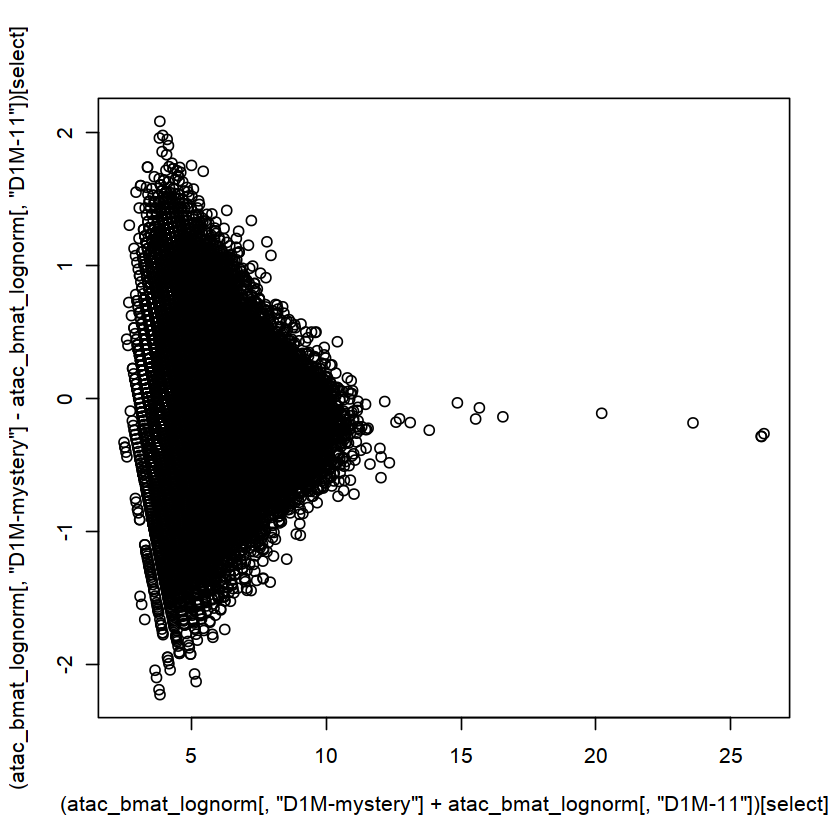

In [968]:
select = atac_bmat_lognorm[,"D1M-mystery"] + atac_bmat_lognorm[,"D2M-11"] > 4
plot((atac_bmat_lognorm[,"D1M-mystery"] + atac_bmat_lognorm[,"D1M-11"])[select], 
    (atac_bmat_lognorm[,"D1M-mystery"] - atac_bmat_lognorm[,"D1M-11"])[select])

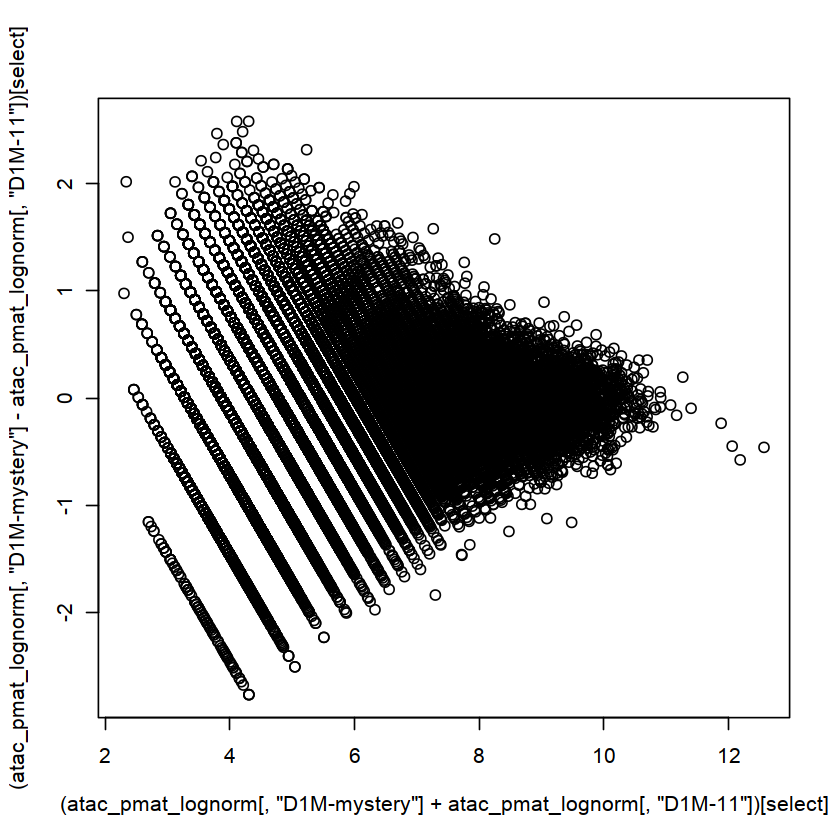

In [987]:
select = atac_pmat_lognorm[,"D1M-mystery"] + atac_pmat_lognorm[,"D2M-11"] > 4
plot((atac_pmat_lognorm[,"D1M-mystery"] + atac_pmat_lognorm[,"D1M-11"])[select], 
    (atac_pmat_lognorm[,"D1M-mystery"] - atac_pmat_lognorm[,"D1M-11"])[select])

In [975]:
cond =  ((atac_bmat_lognorm[,"D1M-mystery"] + atac_bmat_lognorm[,"D1M-11"] > 3.5) & 
    (atac_bmat_lognorm[,"D1M-mystery"] - atac_bmat_lognorm[,"D1M-11"] > 1.25))
sum(cond)

[1] 582

In [996]:
length(unique(queryHits(findOverlaps(atac_bins[cond], fibroblast_peaks))))

[1] 117

In [997]:
length(unique(queryHits(findOverlaps(atac_bins[cond], atac_peaks))))

[1] 353

In [1013]:
cond =  ((atac_pmat_lognorm[,"D1M-mystery"] + atac_pmat_lognorm[,"D1M-11"] > 4) & 
    (atac_pmat_lognorm[,"D1M-mystery"] - atac_pmat_lognorm[,"D1M-11"] > 1.25))
sum(cond)

[1] 1751

In [1018]:
write.table(data.frame(atac_peaks[cond])[,1:3], "~/tmp/homer.mystery.diff.bed",sep='\t', quote=F, row.names=F, col.names=F)

In [1006]:
length(unique(queryHits(findOverlaps(atac_peaks[cond], fibroblast_peaks))))

[1] 455

In [998]:
tmp_peakset = atac_bins[cond]
tmp_peakset

reads_tmp_peakset = Matrix::rowSums(atac_bmat[, unique(queryHits(findOverlaps(atac_bins, tmp_peakset)))])

GRanges object with 685 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
    [1]    chr13     8200000-8205000      *
    [2]    chr13   13885000-13890000      *
    [3]    chr13   16745000-16750000      *
    [4]    chr13   19665000-19670000      *
    [5]    chr13   42560000-42565000      *
    ...      ...                 ...    ...
  [681]     chr9 117120000-117125000      *
  [682]     chr9 122780000-122785000      *
  [683]     chr9 124435000-124440000      *
  [684]     chr9 126660000-126665000      *
  [685]     chr9 134890000-134895000      *
  -------
  seqinfo: 195 sequences from an unspecified genome; no seqlengths

In [1020]:
tmp_peakset = atac_peaks[cond]
tmp_peakset

reads_tmp_peakset = Matrix::rowSums(atac_pmat[, unique(queryHits(findOverlaps(atac_peaks, tmp_peakset)))])

GRanges object with 1751 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]    chr17   38881453-38881954      *
     [2]    chr17   67751372-67751873      *
     [3]    chr17   75013021-75013522      *
     [4]    chr17   45020683-45021184      *
     [5]    chr17   27540290-27540791      *
     ...      ...                 ...    ...
  [1747]     chrX 133726104-133726605      *
  [1748]     chrX   19710039-19710540      *
  [1749]     chrX 106708017-106708518      *
  [1750]     chrX 110415061-110415562      *
  [1751]     chrX   39011549-39012050      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

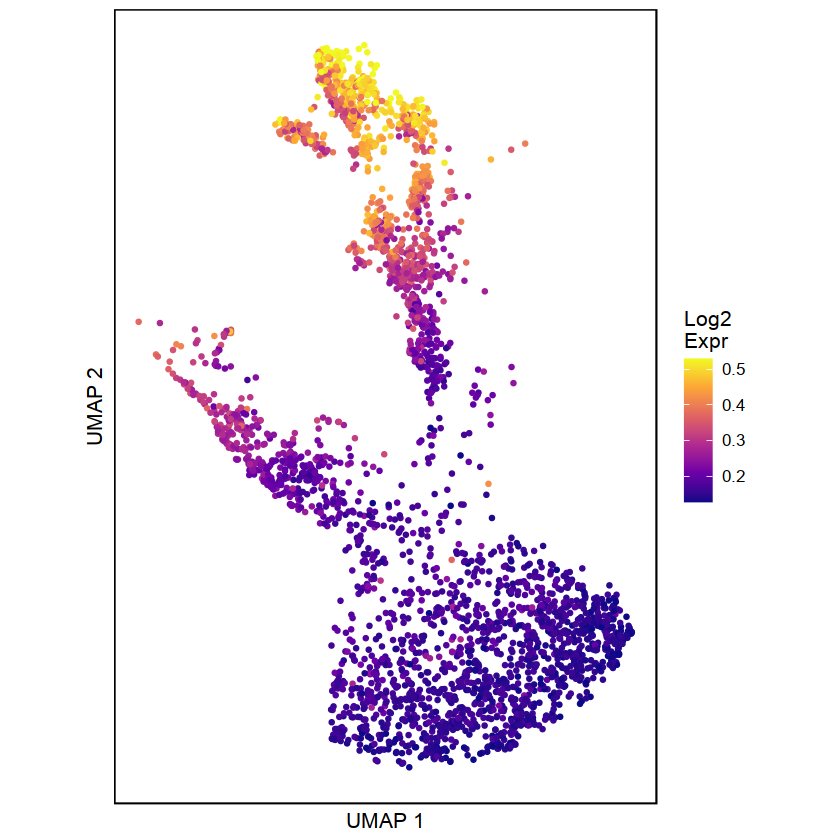

In [1022]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals(1-(reads_tmp_peakset/pmat_rsums)[atac_metaData$sample!="D2"],
         selection=atac_metaData_multiome_filt$sample=="D1M")

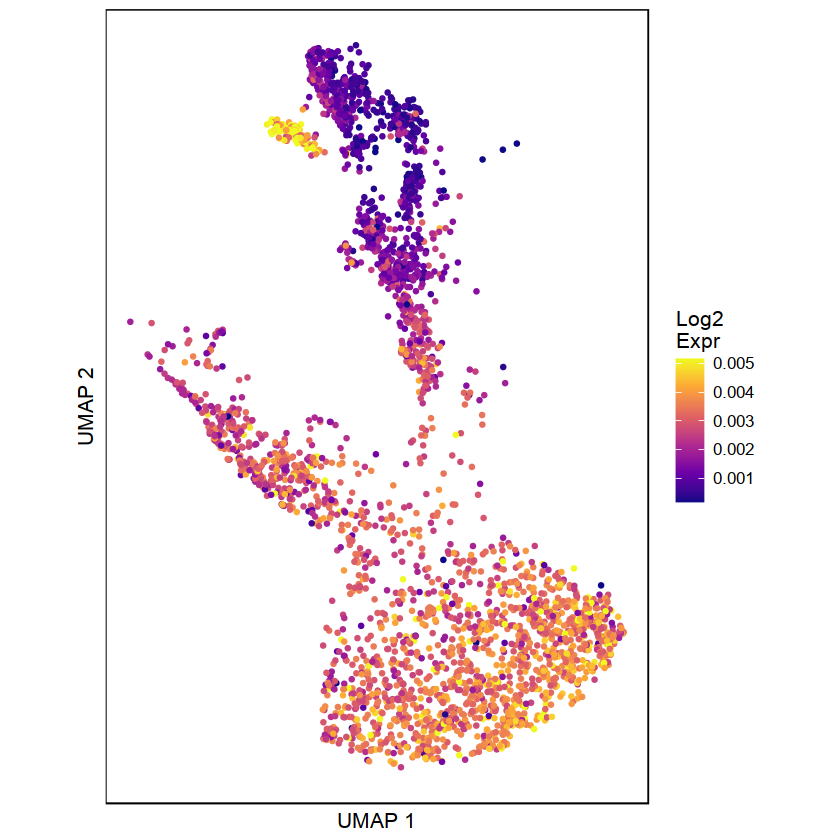

In [1009]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_tmp_peakset/pmat_rsums)[atac_metaData$sample!="D2"],
         selection=atac_metaData_multiome_filt$sample=="D1M")

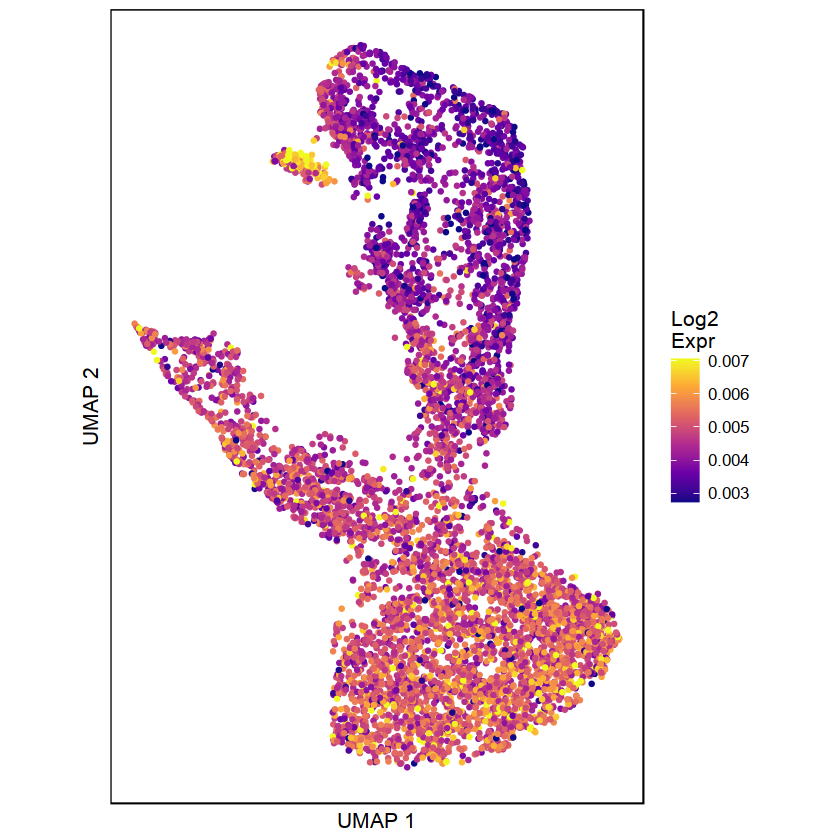

In [979]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((reads_tmp_peakset/rsums)[atac_metaData$sample!="D2"])

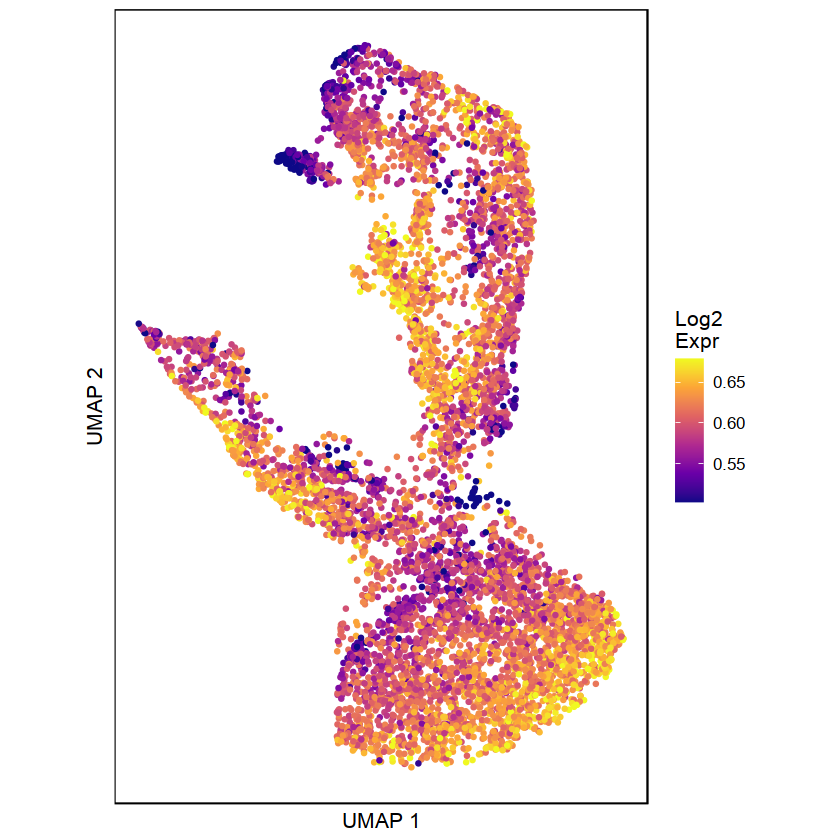

In [980]:
options(repr.plot.width =7 , repr.plot.height = 7)
plot_vals((pmat_rsums/rsums)[atac_metaData$sample!="D2"])

In [930]:
d2m_tss = data.frame(readRDS("../20220603_Multiome_ArchR/QualityControl/D2M/D2M-Pre-Filter-Metadata.rds"))
rownames(d2m_tss) = d2m_tss$cellNames
d1m_tss = data.frame(readRDS("../20220603_Multiome_ArchR/QualityControl/D1M/D1M-Pre-Filter-Metadata.rds"))
rownames(d1m_tss) = d1m_tss$cellNames

m_tss = rbind(d1m_tss, d2m_tss)

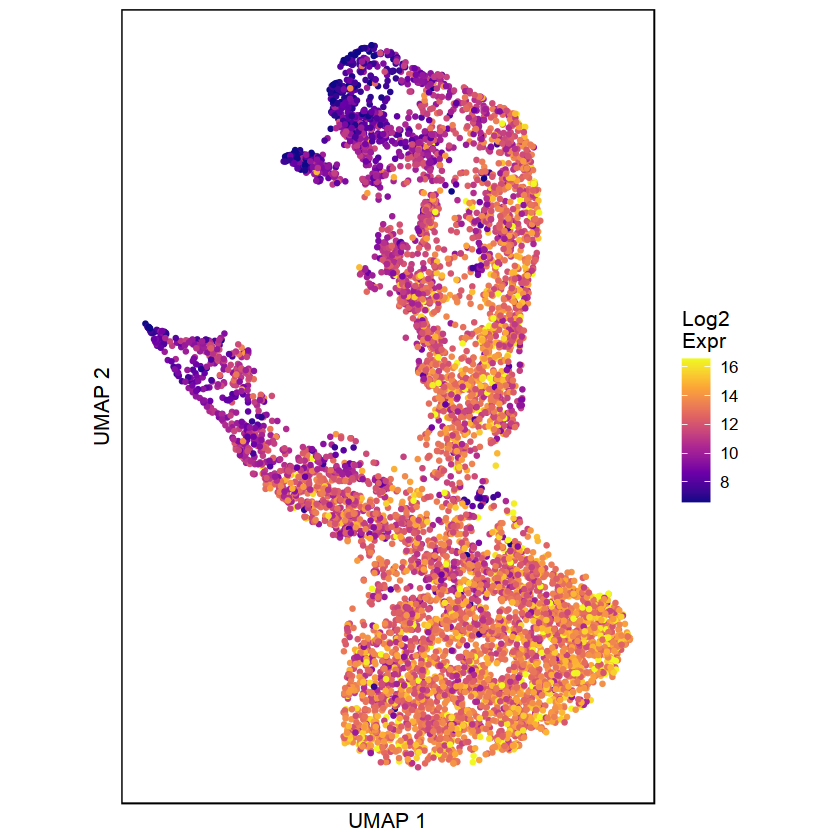

In [1019]:
options(repr.plot.width =7 , repr.plot.height = 7)
tmp = atac_metaData[(atac_metaData$sample!="D2"),]
tmp$val = m_tss[paste(tmp$sample, tmp$barcode, sep='#'), "TSSEnrichment"]# /m_tss[paste(tmp$sample, tmp$barcode, sep='#'), "nFrags"]

ggplot(tmp) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=val)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(tmp$val, 0.01),quantile(tmp$val, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()  

